<table align="center" width=100%>
    <tr>
        <td>
            <div align="center">
                <font color="#21618C" size=8px>
                    <b> Anomaly Detection in Reviews <br>
                    </b>
                </font>
            </div>
        </td>
    </tr>
</table>

<h1 class="list-group-item list-group-item-action active" data-toggle="list"  role="tab" aria-controls="home">PROBLEM STATEMENT </h1>

The objective is to build classifier models that identify any inconsistencies or Anomalies between ratings and the reviews given by the Customer, thereby enables to ensure that rating is consistent with the review.

<h2 class="list-group-item list-group-item-action active" data-toggle="list"  role="tab" aria-controls="home">IMPORTING NECESSARY LIBRARIES </h2>

In [1]:
import pandas as pd
import numpy as np

import string
import re
import random

import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud

import nltk
import unicodedata
from bs4 import BeautifulSoup

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report,accuracy_score,f1_score,roc_auc_score,roc_curve,precision_score,recall_score

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from xgboost import XGBClassifier

from sklearn.model_selection import StratifiedKFold,cross_val_score,KFold,cross_validate
from sklearn.model_selection import GridSearchCV

<h2 class="list-group-item list-group-item-action active" data-toggle="list"  role="tab" aria-controls="home">DATASET DETAILS </h2>

We have combined two datasets:

1.	**Amazon Fine Food review** - contains reviews of food from amazon with a data span of more than 10 years from October 2012. This dataset has 10 columns
2.	**Amazon Grocery_Gourmet** - contains user reviews from May 1996 to July 2014. This data set has 9 columns.

A total of around 7.2L records is present in our dataset.

**Attribute details:**

**1. reviewerID** - Unique Identifier for each customer\
**2. asin** - Unique identifier of the product\
**3. reviewerName** - Name of the Reviewer\
**4. helpful** - Number of users who found the review helpful and not helpful\
**5. reviewText** - Detailed review of the product\
**6. Overall** - Rating given by the user for the product\
**7. summary** - Gist of the entire review\
**8. UnixReviewTime** - Timestamp for the review

<table align="center" width=100%>
    <tr>
        <td>
            <div align="center">
                <font color="#21618C" size=6px>
                    <b> DATA PREPROCESSING <br>
                    </b>
                </font>
            </div>
        </td>
</table>

In [2]:
df = pd.read_excel("combined dataset.xlsx",sheet_name='Combined')
df.head(2)

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime
0,A1VEELTKS8NLZB,616719923X,Amazon Customer,"[0, 0]",Just another flavor of Kit Kat but the taste i...,4,Good Taste,1370044800
1,A14R9XMZVJ6INB,616719923X,amf0001,"[0, 1]",I bought this on impulse and it comes from Jap...,3,"3.5 stars, sadly not as wonderful as I had hoped",1400457600


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 719708 entries, 0 to 719707
Data columns (total 8 columns):
reviewerID        719708 non-null object
asin              719708 non-null object
reviewerName      718104 non-null object
helpful           719708 non-null object
reviewText        719683 non-null object
overall           719708 non-null int64
summary           719668 non-null object
unixReviewTime    719708 non-null int64
dtypes: int64(2), object(6)
memory usage: 43.9+ MB


In [4]:
#Checking for duplicated records:

df[df.duplicated(keep='first')==True].shape

#these are the redundant rows

(281, 8)

In [5]:
#removing the duplicated records: duplicated entries
df.drop_duplicates(keep='first',inplace=True)
df.reset_index(drop=True)
print("Shape after duplicate records removal:",df.shape)

Shape after duplicate records removal: (719427, 8)


In [6]:
#Fetching only the required records (rating = 5 & 1) and columns (Review Text, Overall rating) into another dataframe
req_df= df.copy()
req_df=req_df[(req_df['overall']==5)|(req_df['overall']==1)].iloc[:,[4,5]].reset_index(drop=True)
req_df.head()

,reviewText,overall
0,"I had never had it before, was curious to see ...",5
1,Creamy white chocolate infused with Matcha gre...,5
2,After hearing mixed opinions about these Kit K...,5
3,"I love green tea, I love Kit Kats, but the two...",1
4,I ordered these in Summer so they of course ar...,5


<h2 class="list-group-item list-group-item-action active" data-toggle="list"  role="tab" aria-controls="home"> Working with Required Dataset</h2>

In [7]:
#checking the shape
req_df.shape

(508392, 2)

In [8]:
#Checking for null values
req_df.isnull().sum()

reviewText    15
overall        0
dtype: int64

In [9]:
#Dropping null value records of Review Text Attribute

req_df.dropna(subset=['reviewText'],inplace = True)
print(req_df.isnull().sum())
print("\n","Shape of dataset after null value treatment:",req_df.shape)

reviewText    0
overall       0
dtype: int64

 Shape of dataset after null value treatment: (508377, 2)


In [10]:
#Splitting into two groups 5 star and 1 star ratings
df_pos = pd.DataFrame(req_df[req_df['overall']==5])
df_neg = pd.DataFrame(req_df[req_df['overall']==1])

In [11]:
print(df_pos.shape)
print(df_neg.shape)

(450371, 2)
(58006, 2)


In [12]:
#Distribution of target variable in the dataset:
d =pd.DataFrame(req_df['overall'].value_counts())
d['percent'] = round(d['overall']/len(req_df)*100,2)
d

,overall,percent
5,450371,88.59
1,58006,11.41


C:\Anaconda\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


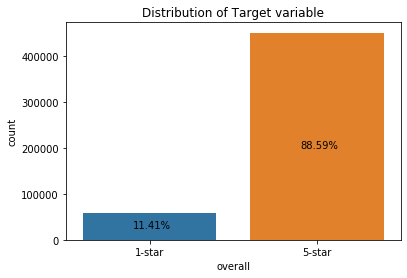

In [13]:
#Visualization:
a = sns.countplot(req_df['overall'])
a.set_xticklabels(['1-star','5-star'], rotation=0)
plt.text(x=-0.1,y=25000,s=str(d['percent'][1])+"%")
plt.text(x=0.9,y=200000,s=str(d['percent'][5])+"%")
plt.title("Distribution of Target variable")
plt.show()

#We can see the data is imbalanced only 11.6% of data has records for 1 star

<h2 class="list-group-item list-group-item-action active" data-toggle="list"  role="tab" aria-controls="home"> TAKING BALANCED DATASET</h2>

As observed above, records for 1-star rating account to only about 11% of entire dataset. Hence, we have **taken a balanced dataset comprising 40k records of each category  of target variable**.

In [14]:
positive_df  = df_pos.sample(n=40000,random_state=10).reset_index(drop = True)
positive_df.head(2)

,reviewText,overall
0,mccormicks Worcestershire pepper is absolutely...,5
1,Loved this coffee. It was shipped quickly. Mad...,5


In [15]:
negative_df  = df_neg.sample(n=40000,random_state=10).reset_index(drop = True)
negative_df.head(2)

,reviewText,overall
0,I use honey in my tea and I was hoping to redu...,1
1,Tastes like pine needles!!! I've had other ear...,1


### Total no of records in the dataset:
- 7,19,708 records before removal of duplicates
- No of redundant rows: 281
- 7,19,427 after removal of duplicates

<br>

### Total no of 1 & 5 star records :
- 5,08,392 records before null value treatment
- 15 null values present in reviewText column
- 5,08,377 after null value treatment
- 1 star records (df_neg) : 58,006 -->11.41%
- 5 star records (df_pos) : 4,50,371 -->88.59%

<br>

### Total no of 1 & 5 star records :
- 5,08,392 records before null value treatment
- 15 null values present in reviewText column
- 5,08,377 after null value treatment
- 1 star records (df_neg) : 58,006 -->11.41%
- 5 star records (df_pos) : 4,50,371 -->88.59%

<br>

### Dataframe of 1 star rating records :
> Dataset name = negative_df <br>
> Size = 40k records (randomly selected)

### Dataframe of 5 star rating records :
> Dataset name = positive_df<br>
> Size = 40k records (randomly selected)


### Balanced Dataset 

In [16]:
balanced_dataset = pd.concat([positive_df,negative_df],axis=0)
balanced_dataset.head(2)

,reviewText,overall
0,mccormicks Worcestershire pepper is absolutely...,5
1,Loved this coffee. It was shipped quickly. Mad...,5


In [17]:
#Replacing Overall rating 1 as 0 and 5 as 1:
balanced_dataset['overall'].replace({5:1,1:0},inplace = True)
balanced_dataset['overall'].value_counts()

1    40000
0    40000
Name: overall, dtype: int64

In [18]:
#Shuffling the dataset:
from sklearn.utils import shuffle
balanced_dataset = shuffle(balanced_dataset,random_state = 50)
balanced_dataset.head()

,reviewText,overall
2312,Amy's products are the best and If you buy fro...,1
19580,If you like figs it is difficult to say anythi...,1
27927,I loved these when I ordered and used them las...,0
27337,The package was dated Feb. and I ordered and r...,0
33474,My local grocery store had to stop carrying th...,1


In [19]:
#resetting the index
balanced_dataset.reset_index(drop=True,inplace = True)

In [20]:
balanced_dataset.head(2)

,reviewText,overall
0,Amy's products are the best and If you buy fro...,1
1,If you like figs it is difficult to say anythi...,1


**------------------------------------------------------------------------------------------------------------------------**\
Till now we have performed the basic data preprocessing steps and EDA by:
    1. Removing duplicated records (same reviewer's same review for same product)
    2. Removing the unwanted columns (ex: reviewerID, asin, summary etc..) by fetching only ReviewText and Overall columns
    3. Fetching the records of concern - 1 star & 5 star
    4. Treating the null values in dataset of concern
    5. Analysing the distribution of target variable using countplot
    6. Treating the imbalance 
**Note:** The duplicates present in the reviewText have not been removed considering that different reviewers could have shared the same review. This repetition in a way can help the model capture the pattern associated with such ratings and reviewText

**Next steps** involves the Feature engineering - extracting the features of textual data ie words in our case, Text Cleansing or noise removal, and Converting the textual data to numeric form using appropriate vectorizer, in order to train the model.

**-------------------------------------------------------------------------------------------------------------------------**

<table align="center" width=100%>
    <tr>
        <td>
            <div align="center">
                <font color="#21618C" size=6px>
                    <b> FEATURE EXTRACTION <br>
                    </b>
                </font>
            </div>
        </td>
</table>

### Text Preprocessing begins....

Steps Involved:
    1. Lower case conversion
    2. Accented characters removal
    3. Expansion of contractions
    4. Other Noise entity removal
        1. Removal of stop words
        2. Removal of punctuations
        3. Removal of digits
        4. Removal of URLs
        5. Removal of repeated characters
        6. Removal of extra spaces
        7. Removal of html tags
    5. Tokenization
    6. Stemming/Lemmatization

<h2 class="list-group-item list-group-item-action active" data-toggle="list"  role="tab" aria-controls="home"> 1. LOWER CASE CONVERSION</h2>

It is known that machine treats upper and lower case differently. Hence for the ease of interpretation, the text data will be changed to lower case

In [21]:
balanced_dataset['reviewText_processed'] = balanced_dataset['reviewText'].str.lower()

In [22]:
balanced_dataset.head()

,reviewText,overall,reviewText_processed
0,Amy's products are the best and If you buy fro...,1,amy's products are the best and if you buy fro...
1,If you like figs it is difficult to say anythi...,1,if you like figs it is difficult to say anythi...
2,I loved these when I ordered and used them las...,0,i loved these when i ordered and used them las...
3,The package was dated Feb. and I ordered and r...,0,the package was dated feb. and i ordered and r...
4,My local grocery store had to stop carrying th...,1,my local grocery store had to stop carrying th...


<h2 class="list-group-item list-group-item-action active" data-toggle="list"  role="tab" aria-controls="home"> 2. ACCENTED CHARACTERS CONVERSION</h2>

There may be few phrases in accented form such as 'ñ', 'â'. These accents are removed from the string by using a Python module called Unidecode. 

In [23]:
#Function for removing the accented characters present in the text data
def remove_accented_chars(text):
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    return text
balanced_dataset['reviewText_processed']=balanced_dataset['reviewText_processed'].apply(lambda x:remove_accented_chars(x))

In [24]:
balanced_dataset.head()

,reviewText,overall,reviewText_processed
0,Amy's products are the best and If you buy fro...,1,amy's products are the best and if you buy fro...
1,If you like figs it is difficult to say anythi...,1,if you like figs it is difficult to say anythi...
2,I loved these when I ordered and used them las...,0,i loved these when i ordered and used them las...
3,The package was dated Feb. and I ordered and r...,0,the package was dated feb. and i ordered and r...
4,My local grocery store had to stop carrying th...,1,my local grocery store had to stop carrying th...


<h2 class="list-group-item list-group-item-action active" data-toggle="list"  role="tab" aria-controls="home"> 3. EXPANDING THE CONTRACTIONS</h2>

Contraction is the shortened form of a word like don’t stands for do not, aren’t stands for are not. Like this, we need to expand this contraction in the text data for better analysis

In [25]:
#Creating a dictionary of possible contractions

contract_dict = {"a'ight": 'alright',"ain't":'am not',"amn't":'am not','arencha': 'are not you',"aren't":'are not',"‘bout": 'about',\
                 'cannot': 'can not',"can't": 'cannot',"cap’n":'captain',"'cause": 'because',"’cept":'except',"could've":'could have',\
                 "couldn't":'could not',"couldn't've":'could not have','dammit':'damn it',"daren't":'dare not',"daresn't":'dare not',\
                 "dasn't": 'dare not',"didn't":'did not',"doesn't":'does not',"don't":'do not ','dunno': 'do not know',"d'ye":'do you',\
                 "e'en": 'even',"e'er":'ever',"em'":'them',"everybody's":'everybody is',"everyone's":'everyone is',"fo’c’sle":'forecastle',\
                 "’gainst":'against',"g'day":'good day','gimme':'give me',"giv'n":'given','gonna':'going to',"gon't":'go not','gotta':'got to',\
                 "hadn't":'had not',"had've":'had have',"hasn't":'has not',"haven't": 'have not',"he'd":'he had',"he'll":'he will',"helluva":'hell of a',\
                 "he's":'he is',"here's":'here is',"how'd":'how would',"howdy":'how do you do',"how'll":'how will',"how're":'how are',"how's":'how is',\
                 "'s'":' is',"i'd":'i would',"i'd've":'i would have',"i'll":'i will',"i'm":'i am','imma':'i am about to',"i'm'o":'i am going to','innit':'is it not',\
                 "i've":'i have',"isn't":'is not',"it'd":'it would',"it'll":'it will',"it's":'it is','iunno':'i do not know','kinda': 'kind of',\
                 "let's":'let us',"ma'am":'madam',"mayn't":'may not',"may've":'may have',"methinks":'i think',"mightn't":'might not',"might've": 'might have',\
                 "mustn't":'must not',"mustn't've":'must not have',"must've": 'must have',"‘neath":'beneath',"needn't":'need not',\
                 "ne'er":'never',"n't":'not',"o'clock":'of the clock',"o'er":'over',"ol'":'old',"oughtn't":'ought not',"‘round":'around',"'s":'is',"shalln't": 'shall not',\
                 "shan't": 'shall not',"she'd":'she would',"she'll":'she will',"she's":'she is',"should've":'should have',"shouldn't":'should not',"shouldn't've": 'should not have',\
                 "somebody's":'somebody is',"someone's":'someone is',"something's":'something is',"so're": 'so are',"so’s":'so is',"so’ve":'so have',\
                 "that'll": 'that will',"that're":'that are',"that's": 'that is',"that'd":'that would',"there'd":'there would',"there'll":'there will',\
                 "there're": 'there are',"there's":'there is',"these're":'these are',"these've":'these have',"they'd":'they would',"they'll": 'they will',\
                 "they're": 'they are',"they've": 'they have',"this's": 'this is',"those're": 'those are',"those've": 'those have',"'thout":'without',\
                 "'til": 'until',"'tis":'it is',"to've":'to have',"'twas": 'it was',"'tween": 'between',"'twere":'it were','wanna':'want to',\
                 "wasn't": 'was not',"we'd":'we would',"we'd've":'we would have',"we'll":'we will',"we're": 'we are',"we've": 'we have',"weren't": 'were not',\
                 'whatcha': 'what are you',"what'd": 'what did',"what'll": 'what will',"what're": 'what are',"what's": 'what is',"what've": 'what have',\
                 "when's": 'when is',"where'd":'where did',"where'll":'where will',"where're": 'where are',"where's": 'where is',"where've": 'where have',\
                 "which'd": 'which would',"which'll": 'which will',"which're": 'which are',"which's": 'which is',"which've": 'which have',"who'd":'who would',\
                 "who'd've": 'who would have',"who'll": 'who will',"who're": 'who are',"who's":'who is',"who've": 'who have',"why'd": 'why did',\
                 "why're": 'why are',"why's": 'why is',"willn't": 'will not',"won't": 'will not',"wonnot": 'will not',"would've": 'would have',\
                 "wouldn't": 'would not',"wouldn't've": 'would not have',"y'all": 'you all',"y'all'd've": 'you all would have',"y'all'd'n't've": 'you all would not have',\
                 "y'all're": 'you all are',"y'at": 'you at',"yes’m":'yes madam','yessir': 'yes sir',"you'd": 'you would',"you'll": 'you will',\
                 "you're": 'you are',"you've":'you have'}

In [26]:
#Creating a re.compile object using regex, which can be used later to find or sub the pattern
contraction_reg=re.compile('|'.join(contract_dict.keys()))

#Creating a function for expansion of contraction
def contraction_expansion(text,contraction_dict=contract_dict):
    def replace(match):
        return contraction_dict[match.group(0)]
    return contraction_reg.sub(replace, text)

balanced_dataset['reviewText_processed']=balanced_dataset['reviewText_processed'].apply(lambda x:contraction_expansion(x))

In [27]:
balanced_dataset.head()

,reviewText,overall,reviewText_processed
0,Amy's products are the best and If you buy fro...,1,amyis products are the best and if you buy fro...
1,If you like figs it is difficult to say anythi...,1,if you like figs it is difficult to say anythi...
2,I loved these when I ordered and used them las...,0,i loved these when i ordered and used them las...
3,The package was dated Feb. and I ordered and r...,0,the package was dated feb. and i ordered and r...
4,My local grocery store had to stop carrying th...,1,my local grocery store had to stop carrying th...


<h2 class="list-group-item list-group-item-action active" data-toggle="list"  role="tab" aria-controls="home"> 4. OTHER NOISE ENTITY REMOVAL</h2>

A lot of noise entities like extra spaces, many hyphen marks, stop words, punctuations etc can be observed in the review text data. By following the below steps, these unwanted entities will be removed.

## 1. Removal of digits:

In [28]:
#Function for digits_removal in the text:
def digits_removal(text):
    return (re.sub('[0-9]+'," ",text))

balanced_dataset['reviewText_processed'] = balanced_dataset['reviewText_processed'].apply(lambda x: digits_removal(x))

In [29]:
balanced_dataset.head()

,reviewText,overall,reviewText_processed
0,Amy's products are the best and If you buy fro...,1,amyis products are the best and if you buy fro...
1,If you like figs it is difficult to say anythi...,1,if you like figs it is difficult to say anythi...
2,I loved these when I ordered and used them las...,0,i loved these when i ordered and used them las...
3,The package was dated Feb. and I ordered and r...,0,the package was dated feb. and i ordered and r...
4,My local grocery store had to stop carrying th...,1,my local grocery store had to stop carrying th...


## 2. Removal of HTML tags:

In [30]:
#Function for removing the html tags using the BeautifulSoup library:
def remove_html_tags(text):
    soup = BeautifulSoup(text, "html.parser")
    stripped_text = soup.get_text()
    return stripped_text

balanced_dataset['reviewText_processed'] = balanced_dataset['reviewText_processed'].apply(lambda x: remove_html_tags(x))

In [31]:
balanced_dataset.head()

,reviewText,overall,reviewText_processed
0,Amy's products are the best and If you buy fro...,1,amyis products are the best and if you buy fro...
1,If you like figs it is difficult to say anythi...,1,if you like figs it is difficult to say anythi...
2,I loved these when I ordered and used them las...,0,i loved these when i ordered and used them las...
3,The package was dated Feb. and I ordered and r...,0,the package was dated feb. and i ordered and r...
4,My local grocery store had to stop carrying th...,1,my local grocery store had to stop carrying th...


## 3. Removal of punctuations

In [32]:
import string

#Creating a list of punctuations
punc_list = string.punctuation

#Function for removing the puntuations present in the text data
def punctuation_removal(text):
    translator = str.maketrans(' ', ' ',punc_list)
    return text.translate(translator)

balanced_dataset['reviewText_processed'] = balanced_dataset['reviewText_processed'].apply(lambda x: punctuation_removal(x))

In [33]:
balanced_dataset.head()

,reviewText,overall,reviewText_processed
0,Amy's products are the best and If you buy fro...,1,amyis products are the best and if you buy fro...
1,If you like figs it is difficult to say anythi...,1,if you like figs it is difficult to say anythi...
2,I loved these when I ordered and used them las...,0,i loved these when i ordered and used them las...
3,The package was dated Feb. and I ordered and r...,0,the package was dated feb and i ordered and re...
4,My local grocery store had to stop carrying th...,1,my local grocery store had to stop carrying th...


## 4. Removal of stop words:

Stopwords are the most commonly occurring words in a text which do not provide any valuable information. Examples: they, there, this, where, etc.
NLTK library includes approximately 180 stopwords which can be removed from the text data. It is also possible to add new stopwords using add() method if required. 
**However here, we are going to define a set of stop words and remove them from our text data.**\
**Note:** In our case, stop words like 'No','Not' have been excluded as they are important forms of representing negation/negative sentiments

In [34]:
#Creating a list of possible stopwords present in english language:
stopwords = ['a', 'able', 'about', 'above', 'across', 'after', 'again', 'against', 'all', 'almost', 'also', 'am','another', 'around',\
             'among', 'an', 'and', 'any', 'are', 'as', 'at', 'be', 'because', 'been', 'before', 'being', 'below', 'between', \
             'both', 'br', 'btw','but', 'by', 'c','can', 'cannot', 'could','d', 'dear', 'did', 'do', 'does', 'doing', 'don', 'down', 'during',\
             'each', 'either', 'else','em', 'etc','ever', 'every','everyone','except', 'few', 'for', 'from', 'further', 'get', 'got', 'had', 'has', 'have',\
             'having', 'he', 'her', 'here', 'hers', 'herself','hey', 'hi','him', 'himself', 'his', 'how', 'however', 'href', 'i', 'if', 'in',\
             'into', 'is', 'it', 'its', 'itself', 'just', 'least', 'let', 'likely', 'madam', 'may', 'me', 'might', 'more',\
             'most', 'much', 'must', 'my', 'myself', 'neither', 'nor', 'now', 'of', 'off', 'often', 'on', 'once', 'only', 'or', \
             'other', 'others','our', 'ours', 'ourselves', 'out', 'over', 'own', 'rather', 's', 'said', 'same', 'say', 'says', 'shall', \
             'she', 'should', 'since', 'sir', 'so', 'some','somehow', 'such', 'than', 'that', 'the', 'their', 'theirs', 'them', 'themselves', \
             'then', 'there', 'these', 'they', 'this', 'those', 'through', 'to', 'too', 'u', 'under', 'until', 'up', 'us', 'wants',\
             'was', 'we', 'were', 'what', 'when', 'where', 'which', 'while', 'who', 'whom', 'why', 'will', 'with', 'would', 'yet',\
             'you', 'your', 'yours', 'yourself', 'yourselves']

In [35]:
#Function for stopword removal:
def stopword_removal(text):
    return " ".join([word for word in str(text).split() if word not in set(stopwords)])

balanced_dataset['reviewText_processed'] = balanced_dataset['reviewText_processed'].apply(lambda x: stopword_removal(x))

In [36]:
balanced_dataset.head()

,reviewText,overall,reviewText_processed
0,Amy's products are the best and If you buy fro...,1,amyis products best buy amazon subscribe ship ...
1,If you like figs it is difficult to say anythi...,1,like figs difficult anything negative huge con...
2,I loved these when I ordered and used them las...,0,loved ordered used last year kept extra box co...
3,The package was dated Feb. and I ordered and r...,0,package dated feb ordered received coffee last...
4,My local grocery store had to stop carrying th...,1,local grocery store stop carrying distributor ...


## 5. Removal of repeated characters:

There may be words with repeated characters such as 'gooooood', 'amazingggg' which have to be reduced to the actual words 'good' and 'amazing'..

In [37]:
#function for repeated character removal:
def repeat_char_removal(s):
    pattern = re.compile(r'(.)\1{2,}')
    return pattern.sub(r'\1\1',s)
balanced_dataset['reviewText_processed'] = balanced_dataset['reviewText_processed'].apply(lambda x: repeat_char_removal(x))

In [38]:
balanced_dataset.head()

,reviewText,overall,reviewText_processed
0,Amy's products are the best and If you buy fro...,1,amyis products best buy amazon subscribe ship ...
1,If you like figs it is difficult to say anythi...,1,like figs difficult anything negative huge con...
2,I loved these when I ordered and used them las...,0,loved ordered used last year kept extra box co...
3,The package was dated Feb. and I ordered and r...,0,package dated feb ordered received coffee last...
4,My local grocery store had to stop carrying th...,1,local grocery store stop carrying distributor ...


## 6. Removal of URLs:

In [39]:
#Function for removing the URLs present in the text:
def URL_removal(text):
    return re.sub(r'((www.[^s]+)|(http?[^s]+)|(hrefhttp?[^s]+))',' ',text)
balanced_dataset['reviewText_processed'] = balanced_dataset['reviewText_processed'].apply(lambda x: URL_removal(x))

In [40]:
balanced_dataset.head()

,reviewText,overall,reviewText_processed
0,Amy's products are the best and If you buy fro...,1,amyis products best buy amazon subscribe ship ...
1,If you like figs it is difficult to say anythi...,1,like figs difficult anything negative huge con...
2,I loved these when I ordered and used them las...,0,loved ordered used last year kept extra box co...
3,The package was dated Feb. and I ordered and r...,0,package dated feb ordered received coffee last...
4,My local grocery store had to stop carrying th...,1,local grocery store stop carrying distributor ...


## 7. Removal of extra spaces:

In [41]:
#Function for removing the extra spaces using regular expression:
def space_removal(text):
    return re.sub(' +', ' ', text)

balanced_dataset['reviewText_processed']=balanced_dataset['reviewText_processed'].apply(lambda x: space_removal(x))

In [42]:
balanced_dataset.head()

,reviewText,overall,reviewText_processed
0,Amy's products are the best and If you buy fro...,1,amyis products best buy amazon subscribe ship ...
1,If you like figs it is difficult to say anythi...,1,like figs difficult anything negative huge con...
2,I loved these when I ordered and used them las...,0,loved ordered used last year kept extra box co...
3,The package was dated Feb. and I ordered and r...,0,package dated feb ordered received coffee last...
4,My local grocery store had to stop carrying th...,1,local grocery store stop carrying distributor ...


**------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------**\
Now, basic text cleaning steps have been performed. Further, we would have to break down the text to smaller parts(tokens) and change the words to their root form.\
**------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------**

<h2 class="list-group-item list-group-item-action active" data-toggle="list"  role="tab" aria-controls="home"> 5. TOKENIZATION</h2>

Tokenization is the process of **breaking the raw text into small chunks either into words or sentences called tokens**. It helps in interpreting the meaning of the text by analyzing the sequence of the words. There are different methods and libraries available to perform tokenization. Tokenization can be done to either separate words or sentences. If the text is split into words using some separation technique it is called word tokenization and same separation done for sentences is called sentence tokenization.\
There are various Tokenization techniques such as **White-space tokenization, Dictionary based tokenization, Rule based tokenization,Regular expression tokenizer etc**. NLTK, Spacy, Gensim, Keras are some of the libraries that can be used to accomplish the task.\
Here we are using **NLTK** Natural language tool kit for the purpose of processing the text data.
Tokenization with NLTK : Word_tokenize and sent_tokenize are the simple tokenizers available with NLTK. \
Here, we would be using the **Word Tokenizer** of NLTK.

In [43]:
nltk.download('punkt')

[nltk_data] Error loading punkt: <urlopen error [Errno 11001]
[nltk_data]     getaddrinfo failed>


False

In [43]:
#Importing necessary package
from nltk.tokenize import word_tokenize

balanced_dataset['reviewText_processed'] = balanced_dataset['reviewText_processed'].apply(word_tokenize)

In [44]:
balanced_dataset.head()

,reviewText,overall,reviewText_processed
0,Amy's products are the best and If you buy fro...,1,"[amyis, products, best, buy, amazon, subscribe..."
1,If you like figs it is difficult to say anythi...,1,"[like, figs, difficult, anything, negative, hu..."
2,I loved these when I ordered and used them las...,0,"[loved, ordered, used, last, year, kept, extra..."
3,The package was dated Feb. and I ordered and r...,0,"[package, dated, feb, ordered, received, coffe..."
4,My local grocery store had to stop carrying th...,1,"[local, grocery, store, stop, carrying, distri..."


<h2 class="list-group-item list-group-item-action active" data-toggle="list"  role="tab" aria-controls="home"> 6. LEMMATIZATION</h2>

Lemmatization is the process of converting a word to its base form. The difference between stemming and lemmatization is, lemmatization considers the context and converts the word to its meaningful base form, whereas stemming just removes the last few characters, often leading to incorrect meanings and spelling errors.\
There are various packages available in python to perform Lemmatization. Here, we would be using the simple **WordNet Lemmatizer with pos(parts of speech tag)** of NLTK

In [46]:
nltk.download('wordnet')

[nltk_data] Error loading wordnet: <urlopen error [Errno 11001]
[nltk_data]     getaddrinfo failed>


False

## Lemmatization with POS tag:

In [47]:
nltk.download('averaged_perceptron_tagger')

[nltk_data] Error loading averaged_perceptron_tagger: <urlopen error
[nltk_data]     [Errno 11001] getaddrinfo failed>


False

In [45]:
from nltk import WordNetLemmatizer
from nltk.corpus import wordnet

wlt = WordNetLemmatizer()

In [46]:
def get_pos(s):
    tag = nltk.pos_tag([s])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    return tag_dict.get(tag,wordnet.NOUN)
def lemma_text_pos(text):
    return [wlt.lemmatize(word,get_pos(word)) for word in text]

In [47]:
#Lematizing with parts of speech tag
balanced_dataset['reviewText_processed'] = balanced_dataset['reviewText_processed'].apply(lambda x: lemma_text_pos(x))

In [48]:
balanced_dataset.head(2)

,reviewText,overall,reviewText_processed
0,Amy's products are the best and If you buy fro...,1,"[amyis, product, best, buy, amazon, subscribe,..."
1,If you like figs it is difficult to say anythi...,1,"[like, fig, difficult, anything, negative, hug..."


<h2 class="list-group-item list-group-item-action active" data-toggle="list"  role="tab" aria-controls="home"> SPLITTING INTO DATA AND TARGET</h2>

In [49]:
#only the processed review text and overall attributes are required
balanced_dataset = balanced_dataset.sort_values('overall').reset_index(drop=True)

data = balanced_dataset.drop(['overall'],axis=1)
target = balanced_dataset.overall

<h2 class="list-group-item list-group-item-action active" data-toggle="list"  role="tab" aria-controls="home"> VISUALIZATION OF DATA FOR NEGATIVE & POSITIVE RATINGS</h2>

In [50]:
#for 1 star ratings:
neg_data = balanced_dataset['reviewText_processed'][:40000]
neg_word_bag = []
for i in neg_data:
    for j in i:
        neg_word_bag.append(j)

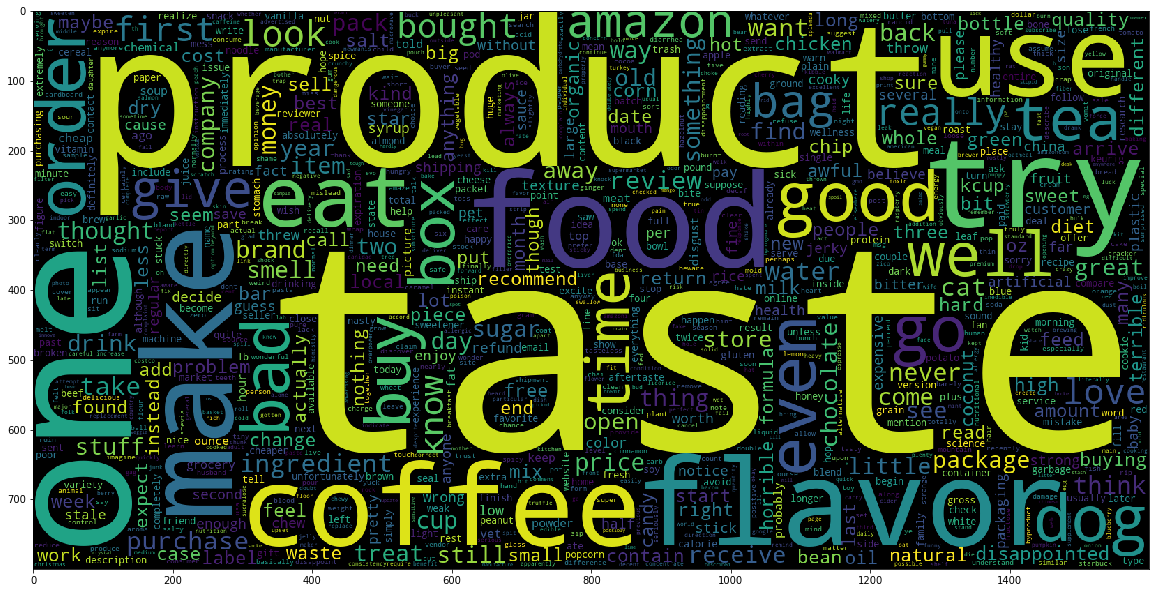

In [54]:
plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800,collocations=False).generate(" ".join(neg_word_bag))
plt.imshow(wc)
plt.show()

We can observe that words representing negative sentiments such as **"one","bad"** have been highlighted which implies the greater usage of these words in records of 1 star ratings.
Also, we can see words like "good","love","try" representing some positive sentiments been highlighted which has to be analysed further.

In [55]:
#for 5 star ratings:
pos_data = balanced_dataset['reviewText_processed'][40000:]
pos_word_bag = []
for i in pos_data:
    for j in i:
        pos_word_bag.append(j)

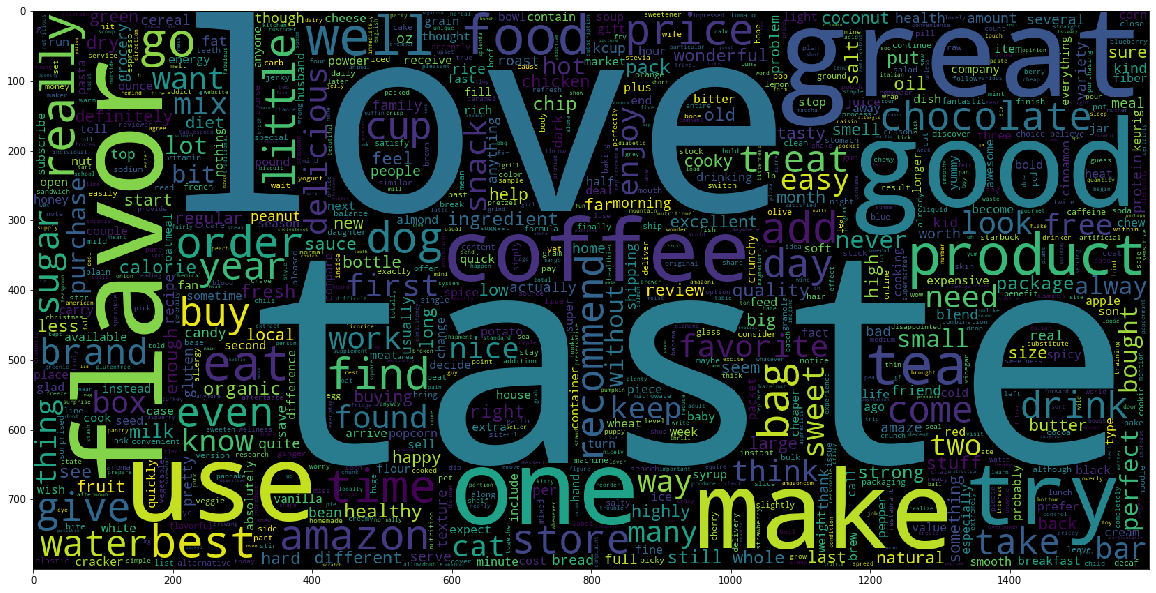

In [56]:
plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800,collocations=False).generate(' '.join(pos_word_bag))
plt.imshow(wc)
plt.show()

We can observe that words representing positive sentiments such as **"good","great","Love"** have been highlighted in a bigger font size which implies the frequencies of these words in records of 5 star ratings is very much higher.

Since the dataset comprises of reviews of food items, we can see words like 'taste','flavor','coffee','food','product' being highlighted in both 1 star and 5 star rating records.

<h2 class="list-group-item list-group-item-action active" data-toggle="list"  role="tab" aria-controls="home"> TRAIN - TEST SPLIT</h2>

In [50]:
#Splitting the data into 80% of training set & 20% of test sets
X_train,X_test,Y_train,Y_test = train_test_split(data,target,test_size=0.2,random_state=10,shuffle=True,stratify=target)
print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)

(64000, 2)
(64000,)
(16000, 2)
(16000,)


<table align="center" width=100%>
    <tr>
        <td>
            <div align="center">
                <font color="#21618C" size=6px>
                    <b> TEXT TO NUMBER CONVERSION <br>
                    </b>
                </font>
            </div>
        </td>
</table>

<h2 class="list-group-item list-group-item-action active" data-toggle="list"  role="tab" aria-controls="home"> TRANSFORMING THE DATASET USING TF-IDF VECTORIZER</h2>

In order to train the machine, input data has to be in form of numbers. Therefore, it is important for us to convert our textual data into numbers. 
For this purpose, various text embedding methods are in practice - Count vectorizer, TF-IDF vectorizer etc. Here we'll be using the TF-IDF vectorizer.\
TF-IDF : **Term Frequency Inverse Document Frequency** is a very common algorithm to transform text into a meaningful representation of numbers which is used to fit machine algorithm for prediction\
**How it differs from Count vectorizer?**: Count Vectorizer give number of frequency with respect to index of vocabulary where as tf-idf consider overall documents of weight of words.

TF-IDF works by **penalizing the common words by assigning them lower weights while giving importance to words which are rare in the entire corpus but appear in good numbers in few documents**.

TF = (Number of times a term appears (say good) in a document)/(Number of terms in the given document)
IDF = log(N/n), where, N is the number of documents and n is the number of documents a term good has appeared in.
TF-IDF = TF*IDF

<h4 class="list-group-item list-group-item-action active" data-toggle="list"  role="tab" aria-controls="home"> TO UNDERSTAND TF-IDF </h4>

In [58]:
#consider a series of 3 documents:
sente = pd.Series(['Product good. Features good','Taste delicious','Taste bad. Not recommended'])
sente

0    Product good. Features good
1                Taste delicious
2     Taste bad. Not recommended
dtype: object

In [59]:
#Fitting the documents to vectorizer in order to extract the features
vec = TfidfVectorizer(ngram_range=(1,1))
vec.fit(sente)
print(vec.get_feature_names())

['bad', 'delicious', 'features', 'good', 'not', 'product', 'recommended', 'taste']


In [60]:
vec.vocabulary_

{'product': 5,
 'good': 3,
 'features': 2,
 'taste': 7,
 'delicious': 1,
 'bad': 0,
 'not': 4,
 'recommended': 6}

In [61]:
vec.idf_

array([1.69314718, 1.69314718, 1.69314718, 1.69314718, 1.69314718,
       1.69314718, 1.69314718, 1.28768207])

In [62]:
#Transforming the documents to numerical data
sente_trans = vec.transform(sente)
pd.DataFrame(sente_trans.toarray(),columns = vec.get_feature_names())

,bad,delicious,features,good,not,product,recommended,taste
0,0.000000,0.000000,0.408248,0.816497,0.000000,0.408248,0.000000,0.000000
1,0.000000,0.795961,0.000000,0.000000,0.000000,0.000000,0.000000,0.605349
2,0.528635,0.000000,0.000000,0.000000,0.528635,0.000000,0.528635,0.402040


<h2 class="list-group-item list-group-item-action active" data-toggle="list"  role="tab" aria-controls="home"> 1. FOR ONLY UNI - GRAM </h2>

In [53]:
vectoriser_01 = TfidfVectorizer(ngram_range=(1,1)) 
vectoriser_01.fit([" ".join(i) for i in X_train.iloc[:,1]])
print('No. of feature_words: ', len(vectoriser_01.get_feature_names()))

No. of feature_words:  74441


In [53]:
#transforming the train and test sets
X_train_01 = vectoriser_01.transform([" ".join(i) for i in X_train.iloc[:,1]])
X_test_01  = vectoriser_01.transform([" ".join(x) for x in X_test.iloc[:,1]])

In [54]:
#Fetching the features:
print('Uni Gram feature_words: ', vectoriser_01.get_feature_names()[4060:4071])

Uni Gram feature_words:  ['ave', 'avelinden', 'avent', 'avenue', 'aver', 'average', 'averageatbest', 'averagebad', 'averageconsistency', 'averageis', 'averagesized']


<h2 class="list-group-item list-group-item-action active" data-toggle="list"  role="tab" aria-controls="home"> 2. FOR UNI - GRAM & BI - GRAM COMBINATION</h2>

In [51]:
vectoriser = TfidfVectorizer(ngram_range=(1,2)) 
vectoriser.fit([" ".join(i) for i in X_train.iloc[:,1]])
print('No. of feature_words: ', len(vectoriser.get_feature_names()))

No. of feature_words:  954868


In [52]:
#transforming the train and test sets
X_train_1 = vectoriser.transform([" ".join(i) for i in X_train.iloc[:,1]])
X_test_1  = vectoriser.transform([" ".join(x) for x in X_test.iloc[:,1]])

In [53]:
#Fetching the features:
print('Uni-Bi Gram feature_words: ', vectoriser.get_feature_names()[80000:80011])

Uni-Bi Gram feature_words:  ['black tar', 'black tarry', 'black taste', 'black tea', 'black teaand', 'black teabag', 'black teacaribou', 'black teai', 'black teais', 'black tealoose', 'black teascoincidentally']


<h2 class="list-group-item list-group-item-action active" data-toggle="list"  role="tab" aria-controls="home"> 3. FOR ONLY BI - GRAMS </h2>

In [58]:
vectoriser_2 = TfidfVectorizer(ngram_range=(2,2))
vectoriser_2.fit([" ".join(i) for i in X_train.iloc[:,1]])
print('No. of feature_words only bi grams: ', len(vectoriser_2.get_feature_names()))

No. of feature_words only bi grams:  880427


In [59]:
#transforming the train and test sets
X_train_2 = vectoriser_2.transform([" ".join(i) for i in X_train.iloc[:,1]])
X_test_2  = vectoriser_2.transform([" ".join(x) for x in X_test.iloc[:,1]])

In [60]:
#Fetching the features:
print('Only Bi Gram feature_words: ', vectoriser_2.get_feature_names()[70000:70011])

Only Bi Gram feature_words:  ['biscuit shortcake', 'biscuit side', 'biscuit similar', 'biscuit size', 'biscuit small', 'biscuit soft', 'biscuit spoon', 'biscuit sprinkle', 'biscuit still', 'biscuit strongly', 'biscuit stuck']


<h2 class="list-group-item list-group-item-action active" data-toggle="list"  role="tab" aria-controls="home"> 4. FOR ONLY TRI - GRAM </h2>

In [61]:
vectoriser_3 = TfidfVectorizer(ngram_range=(3,3))
vectoriser_3.fit([" ".join(i) for i in X_train.iloc[:,1]])
print('No. of feature_words only tri grams: ', len(vectoriser_3.get_feature_names()))

No. of feature_words only tri grams:  1735303


In [62]:
#transforming the train and test sets
X_train_3 = vectoriser_3.transform([" ".join(i) for i in X_train.iloc[:,1]])
X_test_3  = vectoriser_3.transform([" ".join(x) for x in X_test.iloc[:,1]])

In [63]:
#Fetching the features:
print('Tri Gram feature_words: ', vectoriser_3.get_feature_names()[80000:80011])

Tri Gram feature_words:  ['back injury use', 'back innova evo', 'back inside ask', 'back inside keep', 'back inside sweeten', 'back inspect time', 'back instantly elevate', 'back instead bake', 'back instead go', 'back instead let', 'back instead saeco']


<h2 class="list-group-item list-group-item-action active" data-toggle="list"  role="tab" aria-controls="home"> FUNCTION FOR EVALUATION OF METRICS FOR N_GRAM SELECTION </h2>

In [64]:
def N_Gram_model_eval(model,X_test,Y_test,model_name='LR_model'):
    Y_pred = model.predict(X_test)  #making the prediction from X_test
    Y_pred_proba = model.predict_proba(X_test) #getting the probability of predicted values 
    
    cm = confusion_matrix(Y_test,Y_pred)
    print("Confusion matrix:\n",cm) #Displaying the confusion matrix
    print("Classification Report\n",classification_report(Y_test,Y_pred)) #Displaying the classification report
    print("Accuracy score:",accuracy_score(Y_test,Y_pred))
    #Plotting the confusion matrix
    conf_matrix = pd.DataFrame(data=cm,columns = ['Predicted: 0','Predicted:1'],index=['Actual:0','Actual:1'])
    tags = ['True Negative','False Positive','False Negative','True Positive']
    tag_values = [str(value) for value in cm.flatten()]
    labels = [f'{i}\n{j}' for i, j in zip(tags,tag_values)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(conf_matrix, annot = labels, cmap = 'ocean',fmt='',annot_kws = {'fontsize':12,'color':'black'},cbar=False)
    plt.title ("Confusion Matrix", fontdict = {'size':15},pad=20)
    plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
    plt.ylabel("Actual values" , fontdict = {'size':14}, labelpad = 10)
    plt.axis('equal')
    plt.tight_layout()
    plt.show()
    
    #Plotting the ROC curve
    fpr,tpr,threshold = roc_curve(Y_test,Y_pred_proba[:,1])
    auc_score = round(roc_auc_score(Y_test, Y_pred_proba[:,1]),4)
    plt.plot(fpr,tpr)
    plt.xlim([0.0,1.0])
    plt.ylim([0.0,1.0])
    plt.plot([0,1],[0,1],'r--')
    plt.title('ROC curve for Sentiment Classification', fontsize = 15)
    plt.xlabel('False positive rate (1-Specificity)', fontsize = 15)
    plt.ylabel('True positive rate (Sensitivity)', fontsize = 15)
    plt.text(x = 0.2, y = 0.9, s = ('AUC Score:',auc_score ))
    plt.grid(True)
    plt.show()
    
    #Creating a series of metrices to be consolidated in a dataframe
    model_metrics = pd.Series({'Model_Name': model_name,'Precision': precision_score(Y_test,Y_pred),
                               'Recall': recall_score(Y_test,Y_pred),'Accuracy_score': accuracy_score(Y_test,Y_pred),
                               'F1-score':f1_score(Y_test,Y_pred),'AUC_Score': round(roc_auc_score(Y_test, Y_pred_proba[:,1]),4)})
    return model_metrics

In [65]:
#Creating a result table to evaluate the results of each of the N_grams model
cols = ['Model_Name','Precision', 'Recall', 'Accuracy_score', 'F1-score','AUC_Score']
Ngram_eval_table = pd.DataFrame(columns = cols)

<table align="center" width=100%>
    <tr>
        <td>
            <div align="center">
                <font color="#21618C" size=6px>
                    <b> N-GRAM SELECTION - BASE MODEL : LOGISTIC REGRESSION <br>
                    </b>
                </font>
            </div>
        </td>
</table>

<h2 class="list-group-item list-group-item-action active" data-toggle="list"  role="tab" aria-controls="home"> 1. FOR ONLY UNI - GRAM  </h2>

In [66]:
LRmodel_01 = LogisticRegression(random_state=10)
LRmodel_01.fit(X_train_01, Y_train)

LogisticRegression(random_state=10)

Confusion matrix:
 [[7381  619]
 [ 714 7286]]
Classification Report
               precision    recall  f1-score   support

           0       0.91      0.92      0.92      8000
           1       0.92      0.91      0.92      8000

    accuracy                           0.92     16000
   macro avg       0.92      0.92      0.92     16000
weighted avg       0.92      0.92      0.92     16000

Accuracy score: 0.9166875


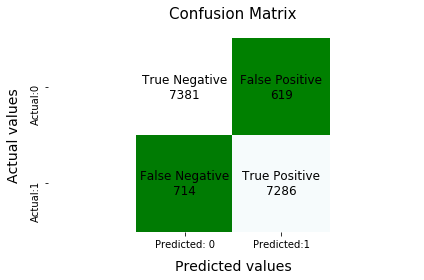

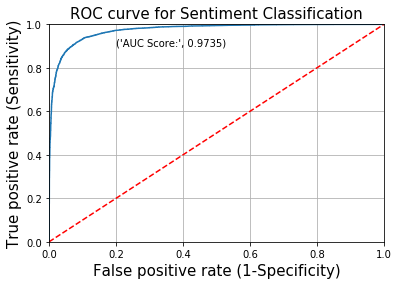

,Model_Name,Precision,Recall,Accuracy_score,F1-score,AUC_Score
0,LR_model_only_uni_grams,0.921695,0.91075,0.916687,0.91619,0.9735


In [67]:
m = N_Gram_model_eval(LRmodel_01,X_test_01,Y_test,model_name='LR_model_only_uni_grams')
Ngram_eval_table = Ngram_eval_table.append(m,ignore_index=True)
Ngram_eval_table

<h2 class="list-group-item list-group-item-action active" data-toggle="list"  role="tab" aria-controls="home"> 2. FOR UNI - GRAM & BI - GRAM COMBINATION</h2>

In [68]:
LRmodel_1 = LogisticRegression(random_state=10)
LRmodel_1.fit(X_train_1, Y_train)

LogisticRegression(random_state=10)

Confusion matrix:
 [[7466  534]
 [ 562 7438]]
Classification Report
               precision    recall  f1-score   support

           0       0.93      0.93      0.93      8000
           1       0.93      0.93      0.93      8000

    accuracy                           0.93     16000
   macro avg       0.93      0.93      0.93     16000
weighted avg       0.93      0.93      0.93     16000

Accuracy score: 0.9315


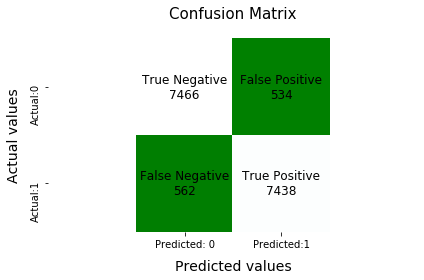

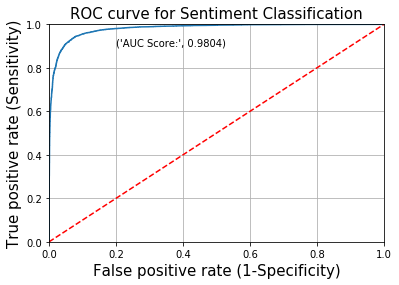

,Model_Name,Precision,Recall,Accuracy_score,F1-score,AUC_Score
0,LR_model_only_uni_grams,0.921695,0.91075,0.916687,0.91619,0.9735
1,LR_model_uni_bigrams,0.933016,0.92975,0.931500,0.93138,0.9804


In [69]:
m = N_Gram_model_eval(LRmodel_1,X_test_1,Y_test,model_name='LR_model_uni_bigrams')
Ngram_eval_table = Ngram_eval_table.append(m,ignore_index=True)
Ngram_eval_table

<h2 class="list-group-item list-group-item-action active" data-toggle="list"  role="tab" aria-controls="home"> 3. FOR ONLY BI - GRAMS </h2>

In [70]:
LRmodel_2 = LogisticRegression(random_state=10)
LRmodel_2.fit(X_train_2, Y_train)

LogisticRegression(random_state=10)

Confusion matrix:
 [[7192  808]
 [ 639 7361]]
Classification Report
               precision    recall  f1-score   support

           0       0.92      0.90      0.91      8000
           1       0.90      0.92      0.91      8000

    accuracy                           0.91     16000
   macro avg       0.91      0.91      0.91     16000
weighted avg       0.91      0.91      0.91     16000

Accuracy score: 0.9095625


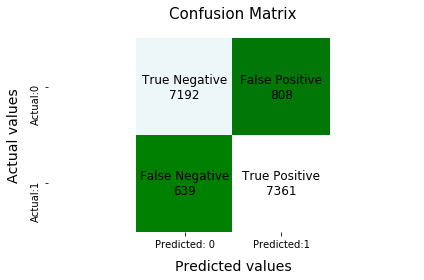

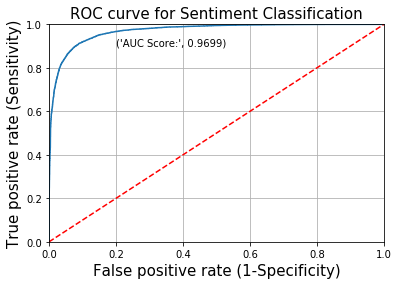

,Model_Name,Precision,Recall,Accuracy_score,F1-score,AUC_Score
0,LR_model_only_uni_grams,0.921695,0.910750,0.916687,0.916190,0.9735
1,LR_model_uni_bigrams,0.933016,0.929750,0.931500,0.931380,0.9804
2,LR_model_only_bigrams,0.901089,0.920125,0.909563,0.910508,0.9699


In [71]:
m = N_Gram_model_eval(LRmodel_2,X_test_2,Y_test,model_name='LR_model_only_bigrams')
Ngram_eval_table = Ngram_eval_table.append(m,ignore_index=True)
Ngram_eval_table

<h2 class="list-group-item list-group-item-action active" data-toggle="list"  role="tab" aria-controls="home"> 4. FOR ONLY TRI - GRAM </h2>

In [72]:
LRmodel_3 = LogisticRegression(random_state=10)
LRmodel_3.fit(X_train_3, Y_train)

LogisticRegression(random_state=10)

Confusion matrix:
 [[5817 2183]
 [ 495 7505]]
Classification Report
               precision    recall  f1-score   support

           0       0.92      0.73      0.81      8000
           1       0.77      0.94      0.85      8000

    accuracy                           0.83     16000
   macro avg       0.85      0.83      0.83     16000
weighted avg       0.85      0.83      0.83     16000

Accuracy score: 0.832625


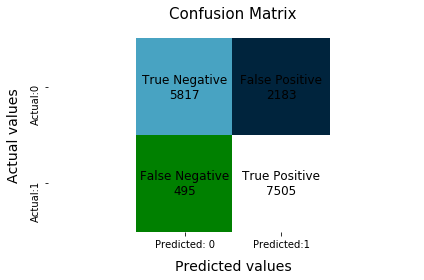

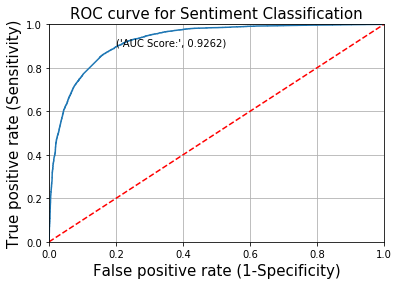

,Model_Name,Precision,Recall,Accuracy_score,F1-score,AUC_Score
0,LR_model_only_uni_grams,0.921695,0.910750,0.916687,0.916190,0.9735
1,LR_model_uni_bigrams,0.933016,0.929750,0.931500,0.931380,0.9804
2,LR_model_only_bigrams,0.901089,0.920125,0.909563,0.910508,0.9699
3,LR_model_only_trigrams,0.774670,0.938125,0.832625,0.848598,0.9262


In [73]:
m = N_Gram_model_eval(LRmodel_3,X_test_3,Y_test,model_name='LR_model_only_trigrams')
Ngram_eval_table = Ngram_eval_table.append(m,ignore_index=True)
Ngram_eval_table

<h2 class="list-group-item list-group-item-action active" data-toggle="list"  role="tab" aria-controls="home"> SCORING METRICS FOR N - GRAM SELECTION </h2>

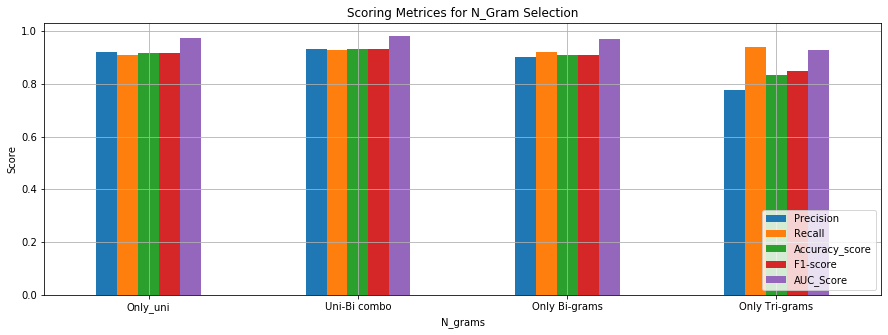

In [85]:
Ngram_eval_table.plot(kind='bar',figsize = (15,5),rot=0)
plt.xticks(np.arange(4),labels = ('Only_uni','Uni-Bi combo','Only Bi-grams','Only Tri-grams'))
plt.xlabel('N_grams')
plt.ylabel('Score')
plt.grid(True)
plt.title("Scoring Metrices for N_Gram Selection")
plt.legend(loc='lower right')
plt.show()

**------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------**\
At this point, our focus is on how well the sentiment classification model is able to predict the sentiments. Machine predicted anamolies here are FN & FP, **Both Recall score and Precision score** are equally important to be kept high and hence to strike a balance between Precision & Recall score, **F1 score** plays a vital role here in deciding the model performance of our sentiment analysis models.\
From the above metrices table, we can see that the model created using the vectorizer with N_grams as **'unigram - bigram combination' gives us the best F1 score**.Therefore, **we will consider Uni-Bigrams combination for further analysis**.

Also, it could be noted that since we have taken a balanced dataset accuracy and f1 score are almost the same \
**------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------**

<h3 class="list-group-item list-group-item-action active" data-toggle="list"  role="tab" aria-controls="home"> Function for Evaluation of Cross Validation Scores for Classifier Model Selection</h3>

In [68]:
def model_eval(model,X_train,y_train,kf = StratifiedKFold(n_splits=7)):
    metrices = ['precision','recall','accuracy','f1']
    scores = pd.DataFrame()
    values = cross_validate(estimator = model,X = X_train, y = y_train, cv=kf,scoring = metrices,n_jobs=-1)
    scores = pd.DataFrame(values).iloc[:,2:]
    scores.columns = metrices
    return scores

In [69]:
def get_scores(df):
    model_eval_metrics = np.array([[round(df['precision'].mean(),4)],[round(df['precision'].std(),4)],\
                                   [round(df['recall'].mean(),4)],[round(df['recall'].std(),4)],\
                                   [round(df['accuracy'].mean(),4)],[round(df['accuracy'].std(),4)],\
                                   [round(df['f1'].mean(),4)],[round(df['f1'].std(),4)]])                                
    return model_eval_metrics

In [70]:
#Creating a result table to evaluate the results of each of the Classifier models
Metrices = [('Precision','Mean'),('Precision','Std dev'), ('Recall','Mean'),('Recall','Std dev'),\
            ('Accuracy','Mean'),('Accuracy','Std dev'),('F1_score','Mean'),('F1_score','Std dev')]
index = pd.MultiIndex.from_tuples(Metrices,names=['Metric','Score'])
results_table = pd.DataFrame(index=index)

<table align="center" width=100%>
    <tr>
        <td>
            <div align="center">
                <font color="#21618C" size=6px>
                    <b> MODEL BUILDING : FOR SENTIMENT CLASSIFICATION <br>
                    </b>
                </font>
            </div>
        </td>
</table>

<h2 class="list-group-item list-group-item-action active" data-toggle="list"  role="tab" aria-controls="home"> K - FOLD CROSS VALIDATION </h2>

### Using the Train set transformed by the vectorizer having `Uni-bi gram combination`, we will now perform corss validation on the different classifier models and compare the performances. For our Analysis, we would be considering the below Classification models:
<br>

1. Logistic Regression
2. Multinomial Naive Bayes

<br>

__Ensemble Techniques__:
1. Random Forest
2. XGBoost Classifier

**Note:** All the models are built with default parameters

## To find the value of N-splits: 

In [89]:
#checking the accuracy scores for N_splits = 5
kf = StratifiedKFold(n_splits = 5)
accuracy_scores = cross_val_score(estimator = LogisticRegression(random_state=10),X = X_train_1, y = Y_train, cv=kf,scoring = 'accuracy')
print("Average score:",accuracy_scores.mean())
print("Std score:",accuracy_scores.std())

Average score: 0.9262656249999999
Std score: 0.0017934069793970422


In [90]:
#checking the accuracy scores for N_splits = 7
kf = StratifiedKFold(n_splits = 7)
accuracy_scores = cross_val_score(estimator = LogisticRegression(random_state=10),X = X_train_1, y = Y_train, cv=kf,scoring = 'accuracy')
print("Average score:",accuracy_scores.mean())
print("Std score:",accuracy_scores.std())

Average score: 0.9268281231836883
Std score: 0.001657775424137479


In [91]:
#checking the accuracy scores for N_splits = 10
kf = StratifiedKFold(n_splits = 10)
accuracy_scores = cross_val_score(estimator = LogisticRegression(random_state=10),X = X_train_1, y = Y_train, cv=kf,scoring = 'accuracy')
print("Average score:",accuracy_scores.mean())
print("Std score:",accuracy_scores.std())

Average score: 0.927671875
Std score: 0.0023306404196325597


We can see that for N-splits = 7, there is a good trade off between average score and standard deviation compared to case where N_splits = 5 or 10. Hence we will **use N_splits =7 for Cross validating our Classifier Models**

## Cross - validation to be performed for `7- Fold`

<h3 class="list-group-item list-group-item-action active" data-toggle="list"  role="tab" aria-controls="home"> 1. LOGISTIC REGRESSION - 7 FOLD CROSS VALIDATION </h3>

In [92]:
%%time

LR_model = LogisticRegression(random_state=10)
m = model_eval(LR_model, X_train_1,Y_train)
results_table['LR_model'] = get_scores(m)

Wall time: 59.2 s


In [93]:
results_table

LR_model
Metric    Score            
Precision Mean       0.9297
          Std dev    0.0021
Recall    Mean       0.9235
          Std dev    0.0043
Accuracy  Mean       0.9268
          Std dev    0.0018
F1_score  Mean       0.9266
          Std dev    0.0019

<h3 class="list-group-item list-group-item-action active" data-toggle="list"  role="tab" aria-controls="home"> 2. MULTINOMIAL NAIVE BAYES - 7 FOLD CROSS VALIDATION </h3>

In [94]:
%%time

mnb_model = MultinomialNB()
m = model_eval(mnb_model, X_train_1,Y_train)
results_table['MNB_model'] = get_scores(m)

Wall time: 4.68 s


In [95]:
results_table

LR_model  MNB_model
Metric    Score                       
Precision Mean       0.9297     0.9412
          Std dev    0.0021     0.0025
Recall    Mean       0.9235     0.9122
          Std dev    0.0043     0.0040
Accuracy  Mean       0.9268     0.9276
          Std dev    0.0018     0.0017
F1_score  Mean       0.9266     0.9264
          Std dev    0.0019     0.0019

<h2 class="list-group-item list-group-item-action active" data-toggle="list"  role="tab" aria-controls="home"> ENSEMBLE TECHNIQUES </h2>

<h3 class="list-group-item list-group-item-action active" data-toggle="list"  role="tab" aria-controls="home"> 1. BAGGING: RANDOM FOREST - 7 FOLD CROSS VALIDATION </h3>

In [96]:
%%time

rf_model = RandomForestClassifier(random_state=10)
m = model_eval(rf_model, X_train_1,Y_train)
results_table['RF_model'] = get_scores(m)

Wall time: 1h 24min 27s


In [97]:
results_table

LR_model  MNB_model  RF_model
Metric    Score                                 
Precision Mean       0.9297     0.9412    0.9113
          Std dev    0.0021     0.0025    0.0037
Recall    Mean       0.9235     0.9122    0.9349
          Std dev    0.0043     0.0040    0.0030
Accuracy  Mean       0.9268     0.9276    0.9220
          Std dev    0.0018     0.0017    0.0022
F1_score  Mean       0.9266     0.9264    0.9230
          Std dev    0.0019     0.0019    0.0021

<h3 class="list-group-item list-group-item-action active" data-toggle="list"  role="tab" aria-controls="home"> 2. BOOSTING: XGBOOST - 7 FOLD CROSS VALIDATION </h3>

In [98]:
%%time

xg_boost_model = XGBClassifier()
m = model_eval(xg_boost_model, X_train_1,Y_train)
results_table['XGBoost_model'] = get_scores(m)

Wall time: 29min 25s


In [99]:
results_table

LR_model  MNB_model  RF_model  XGBoost_model
Metric    Score                                                
Precision Mean       0.9297     0.9412    0.9113         0.9042
          Std dev    0.0021     0.0025    0.0037         0.0033
Recall    Mean       0.9235     0.9122    0.9349         0.9031
          Std dev    0.0043     0.0040    0.0030         0.0070
Accuracy  Mean       0.9268     0.9276    0.9220         0.9037
          Std dev    0.0018     0.0017    0.0022         0.0026
F1_score  Mean       0.9266     0.9264    0.9230         0.9036
          Std dev    0.0019     0.0019    0.0021         0.0030

From the above table which compares our 4 classifier models on basis of different evaluation metrices, we could observe the following:
1. Logistic Regression model is giving us best F1 score. However it is only slightly better than Multinomial Naive Bayes - by 0.0002
2. Multinomial Naive Bayes model is giving us best accuracy and Precision scores. However, it has to be noted that the difference in accuracy scores between Multinomial Naive bayes and Logistic Regression is not much - only 0.0008
3. Random Forest classifier is doing very well with respect to recall compared to other models
4. XGBoost model gives us consistent scores for all the metrices around 90.3-90.4% but is lesser compared to other models.
The metric on focus here is F1 score. so next step, we will be tuning the above base models with respect to scoring = 'f1' 

<table align="center" width=100%>
    <tr>
        <td>
            <div align="center">
                <font color="#21618C" size=6px>
                    <b> HYPER PARAMETER TUNING <br>
                    </b>
                </font>
            </div>
        </td>
</table>

The above selected 4 sentiment classifier models will be tuned with respect to scoring metric - 'F1' and the parameters that help achieve a good trade off between the mean and standard deviation will be chosen as the best parameters of our tuned model

### Function for evaluation:

In [54]:
def get_results(model):
    f1_means = model.cv_results_['mean_test_score']
    f1_std = model.cv_results_['std_test_score']
    params = model.cv_results_['params']
    #Plotting the Mean score vs Std Dev Score Trade-off
    plt.figure(figsize=(8,5))
    plt.plot(f1_means,f1_std,'bo')
    plt.title('F1-Score: Mean vs StandardDeviation Trade Off')
    plt.xlabel('Mean Score')
    plt.ylabel('Std Dev Score')
    plt.show()
    #Dataframe of the cv results for different params combination
    tune_LR_inter =pd.DataFrame()
    for i,j,k in zip(f1_means,f1_std,params):
        tune_LR_inter = tune_LR_inter.append(pd.DataFrame([(i,j,k)],columns = ['F1-Means','F1-Std','Params']),ignore_index=True)
    return tune_LR_inter

<h3 class="list-group-item list-group-item-action active" data-toggle="list"  role="tab" aria-controls="home"> 1. LOGISTIC REGRESSION </h3>

## For Logistic Regression model , the input parameter that will be tuned is `C` and `solver`

In [101]:
%%time

tuned_params = [{'solver':['lbfgs','saga','sag'],'C':[0.001,0.01,0.1,1,10,100]}]
LR_grid_model = GridSearchCV(estimator=LogisticRegression(random_state=10,max_iter=300,penalty='l2'),param_grid=tuned_params,n_jobs=-1,cv=StratifiedKFold(n_splits=7),scoring = 'f1')
LR_grid = LR_grid_model.fit(X_train_1,Y_train)
print("Best parameters:",LR_grid.best_params_)
print("Best F1 score:",LR_grid.best_score_)

Best parameters: {'C': 100, 'solver': 'lbfgs'}
Best F1 score: 0.9441972301433514
Wall time: 24min 53s


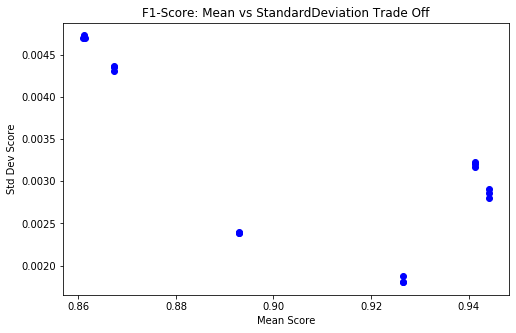

,F1-Means,F1-Std,Params
0,0.860998,0.004701,"{'C': 0.001, 'solver': 'lbfgs'}"
1,0.861119,0.004729,"{'C': 0.001, 'solver': 'saga'}"
2,0.861291,0.004693,"{'C': 0.001, 'solver': 'sag'}"
3,0.867358,0.004355,"{'C': 0.01, 'solver': 'lbfgs'}"
4,0.867296,0.004307,"{'C': 0.01, 'solver': 'saga'}"
5,0.867237,0.004371,"{'C': 0.01, 'solver': 'sag'}"
6,0.892938,0.002385,"{'C': 0.1, 'solver': 'lbfgs'}"
7,0.892952,0.002393,"{'C': 0.1, 'solver': 'saga'}"
8,0.892938,0.002385,"{'C': 0.1, 'solver': 'sag'}"
9,0.926578,0.001801,"{'C': 1, 'solver': 'lbfgs'}"


In [102]:
get_results(LR_grid)

We can see from the above plot that for the parameters C=1, solver='lbfgs' which are the default values, there is a good trade off between the F1 mean score (0.926578) and standard deviation (0.001801). Although for C =1, solver - 'sag' gives a mean score of 0.926609, the difference is only 0.000031 but increase in standard deviation is by 0.000075. Therefore we choose to stick to the **default values of parameters for Logistic Regression Model** C=1, solver='lbfgs'

<h3 class="list-group-item list-group-item-action active" data-toggle="list"  role="tab" aria-controls="home"> 2. MULTINOMIAL NAIVE BAYES </h3>

## For `Multinomial NB` model , the input parameter that will be tuned is `alpha`.

In [103]:
%%time

tuned_params = [{'alpha':[0.001,0.01,0.1,0.5,1,3,5,10,100]}]
MNB_grid_model = GridSearchCV(estimator=MultinomialNB(),param_grid=tuned_params,n_jobs=-1,cv=StratifiedKFold(n_splits=7),scoring = 'f1')
MNB_grid = MNB_grid_model.fit(X_train_1,Y_train)
print("Best parameters:",MNB_grid.best_params_)
print("Best F1 score:",MNB_grid.best_score_)

Best parameters: {'alpha': 0.1}
Best F1 score: 0.9303862452675368
Wall time: 8.13 s


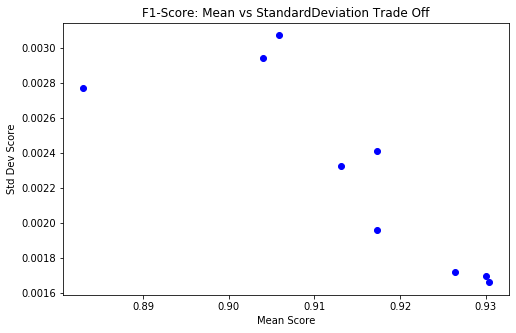

,F1-Means,F1-Std,Params
0,0.904032,0.002940,{'alpha': 0.001}
1,0.917344,0.002412,{'alpha': 0.01}
2,0.930386,0.001660,{'alpha': 0.1}
3,0.930068,0.001698,{'alpha': 0.5}
4,0.926443,0.001721,{'alpha': 1}
5,0.917269,0.001958,{'alpha': 3}
6,0.913125,0.002325,{'alpha': 5}
7,0.905831,0.003072,{'alpha': 10}
8,0.883002,0.002773,{'alpha': 100}


In [104]:
get_results(MNB_grid)

It can be observed that for the best parameter - **alpha = 0.1, there is a good trade off** between the mean score and standard deviation. In fact it has given a better f1 score with lesser standard deviation compared to default parameter value of alpha=1

<h3 class="list-group-item list-group-item-action active" data-toggle="list"  role="tab" aria-controls="home"> 3. RANDOM FOREST MODEL </h3>

## For Random Forest model , the input parameters that will be tuned are `n_estimators`, `criterion`,`max_depth`.

In [105]:
%%time

tuned_params = [{'n_estimators':[100,200,300],'criterion':['gini','entropy'],'max_depth':[50,100,200]}]
rf_grid_model = GridSearchCV(estimator=RandomForestClassifier(random_state=10),param_grid=tuned_params,n_jobs=-1,cv=StratifiedKFold(n_splits=7),scoring = 'f1')
rf_grid = rf_grid_model.fit(X_train_1,Y_train)
print("Best parameters:",rf_grid.best_params_)
print("Best F1 score:",rf_grid.best_score_)

Best parameters: {'criterion': 'entropy', 'max_depth': 200, 'n_estimators': 300}
Best F1 score: 0.9265266999643113
Wall time: 14h 5min 14s


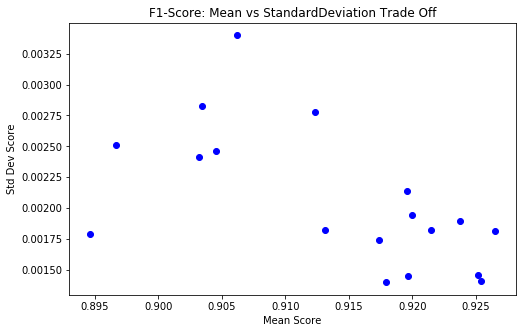

,F1-Means,F1-Std,Params
0,0.896664,0.002511,"{'criterion': 'gini', 'max_depth': 50, 'n_esti..."
1,0.903463,0.002829,"{'criterion': 'gini', 'max_depth': 50, 'n_esti..."
2,0.906152,0.003398,"{'criterion': 'gini', 'max_depth': 50, 'n_esti..."
3,0.913093,0.001824,"{'criterion': 'gini', 'max_depth': 100, 'n_est..."
4,0.917933,0.001399,"{'criterion': 'gini', 'max_depth': 100, 'n_est..."
5,0.919980,0.001944,"{'criterion': 'gini', 'max_depth': 100, 'n_est..."
6,0.919585,0.002135,"{'criterion': 'gini', 'max_depth': 200, 'n_est..."
7,0.923706,0.001898,"{'criterion': 'gini', 'max_depth': 200, 'n_est..."
8,0.925416,0.001412,"{'criterion': 'gini', 'max_depth': 200, 'n_est..."
9,0.894595,0.001789,"{'criterion': 'entropy', 'max_depth': 50, 'n_e..."


In [106]:
get_results(rf_grid)

Here the best parameters chosen would be **'criterion' - entropy, 'max_depth' - 200 and 'n_estimators' - 300** which gives a mean F1 score of 92.65%, standard deviation of 0.001818. When compared to the model with default parameters, we can see that there is a slight improvement in the mean score from 92.3% to 92.7% with a decrease in deviation from 0.0021 to 0.0018

<h3 class="list-group-item list-group-item-action active" data-toggle="list"  role="tab" aria-controls="home"> 4. XG BOOST MODEL </h3>

## For XGBOOST model , the input parameters that will be tuned are `eta`, `gamma`,`max_depth`.

In [55]:
%%time

tuned_params = [{'eta':[0.01,0.1,0.5],'max_depth':[10,15,25],'gamma':[0,0.5,1]}]
xgb_grid_model = GridSearchCV(estimator=XGBClassifier(),param_grid=tuned_params,n_jobs=-1,cv=StratifiedKFold(n_splits=7),scoring = 'f1')
xgb_grid = xgb_grid_model.fit(X_train_1,Y_train)
print("Best parameters:",xgb_grid.best_params_)
print("Best F1 score:",xgb_grid.best_score_)

C:\Anaconda\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:34:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Best parameters: {'eta': 0.5, 'gamma': 0.5, 'max_depth': 25}
Best F1 score: 0.9251430916558914
Wall time: 18h 14min 25s


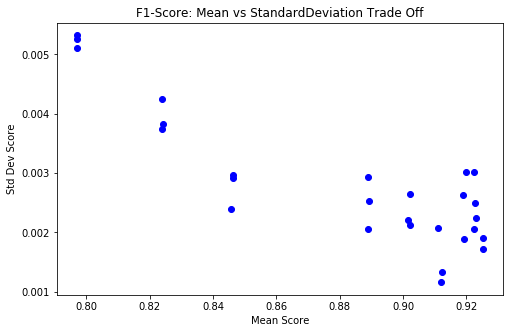

,F1-Means,F1-Std,Params
0,0.797010,0.005104,"{'eta': 0.01, 'gamma': 0, 'max_depth': 10}"
1,0.824078,0.003822,"{'eta': 0.01, 'gamma': 0, 'max_depth': 15}"
2,0.846376,0.002963,"{'eta': 0.01, 'gamma': 0, 'max_depth': 25}"
3,0.797145,0.005322,"{'eta': 0.01, 'gamma': 0.5, 'max_depth': 10}"
4,0.823819,0.003737,"{'eta': 0.01, 'gamma': 0.5, 'max_depth': 15}"
5,0.846348,0.002924,"{'eta': 0.01, 'gamma': 0.5, 'max_depth': 25}"
6,0.797140,0.005266,"{'eta': 0.01, 'gamma': 1, 'max_depth': 10}"
7,0.823869,0.004246,"{'eta': 0.01, 'gamma': 1, 'max_depth': 15}"
8,0.845657,0.002392,"{'eta': 0.01, 'gamma': 1, 'max_depth': 25}"
9,0.889063,0.002935,"{'eta': 0.1, 'gamma': 0, 'max_depth': 10}"


In [56]:
get_results(xgb_grid)

Here the best parameters chosen would be **'eta' - 0.5, 'gamma' - 1, 'max_depth' - 25**. Although the best parameters returned by gridsearch model is for gamma - 0.5, we see that for eta = 0.5, gamma = 1, max_depth = 25, there is better mean vs deviation trade off for gamma=1. When compared to the model with default parameters we can see a significant improvement in mean F1 score from 90.36% to 92.51% and a decrease in standard deviation from 0.003 to 0.0017 which is quite good.

<table align="center" width=100%>
    <tr>
        <td>
            <div align="center">
                <font color="#21618C" size=6px>
                    <b> MODEL EVALUATION <br>
                    </b>
                </font>
            </div>
        </td>
</table>

Our final step of evaluating the tuned models involves a series of steps as follows:
1. Firstly, we will check the performance of the 4 sentiment classifiers on the whole of test data to ensure there is no overfitting issue
2. Next step, we would utilise the statistical technique of sampling the test data using **Cochran's formula** to obtain the sample set on which further evaluation would take place. 
3. Our process involves human intervention at this point where in we manually assign ratings to the review text of Sample test data (by following  certain assumption) and thereby fetch the Anomalies that are present in the sample set.
4. We would then check the model performance on these sample test sets - 
    1. Sentiment Classification
    2. Anomaly Classification
5. Finally make comparison on How well the sentiment classifier model was able to classify the Anomalies present.

<h1 class="list-group-item list-group-item-action active" data-toggle="list"  role="tab" aria-controls="home"> Tuned Model's Performance on Test Data</h1> 

### Function for evaluation of Tuned model's performance

In [53]:
def tuned_model_eval(model,X_test,Y_test,model_name='tuned_model'):
    Y_pred = model.predict(X_test)  #making the prediction from X_test
    Y_pred_proba = model.predict_proba(X_test) #getting the probability of predicted values 
    
    cm = confusion_matrix(Y_test,Y_pred)
    print("Classification Report\n",classification_report(Y_test,Y_pred)) #Displaying the classification report
    
    #Plotting the confusion matrix
    conf_matrix = pd.DataFrame(data=cm,columns = ['Predicted: 0','Predicted:1'],index=['Actual:0','Actual:1'])
    tags = ['True Negative','False Positive','False Negative','True Positive']
    tag_values = [str(value) for value in cm.flatten()]
    labels = [f'{i}\n{j}' for i, j in zip(tags,tag_values)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(conf_matrix, annot = labels, cmap = 'ocean',fmt='',annot_kws = {'fontsize':12,'color':'black'},cbar=False)
    plt.title ("Confusion Matrix", fontdict = {'size':15},pad=20)
    plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
    plt.ylabel("Actual values" , fontdict = {'size':14}, labelpad = 10)
    plt.axis('equal')
    plt.tight_layout()
    plt.show()
    
    #Plotting the ROC curve
    fpr,tpr,threshold = roc_curve(Y_test,Y_pred_proba[:,1])
    auc_score = round(roc_auc_score(Y_test, Y_pred_proba[:,1]),4)
    plt.plot(fpr,tpr)
    plt.xlim([0.0,1.0])
    plt.ylim([0.0,1.0])
    plt.plot([0,1],[0,1],'r--')
    plt.title('ROC curve for Tuned Sentiment Classification Model', fontsize = 15)
    plt.xlabel('False positive rate (1-Specificity)', fontsize = 15)
    plt.ylabel('True positive rate (Sensitivity)', fontsize = 15)
    plt.text(x = 0.2, y = 0.9, s = ('AUC Score:',auc_score ))
    plt.grid(True)
    plt.show()
    
    #Creating a series of metrices to be consolidated in a dataframe
    model_metrics = pd.Series({'Model_Name': model_name,'Precision': precision_score(Y_test,Y_pred),
                               'Recall': recall_score(Y_test,Y_pred),'Accuracy_score': accuracy_score(Y_test,Y_pred),
                               'F1-score':f1_score(Y_test,Y_pred),'AUC_Score': round(roc_auc_score(Y_test, Y_pred_proba[:,1]),4)})
    return model_metrics

In [54]:
#Creating a result table to evaluate the results of each of the tuned model
cols = ['Model_Name','Precision', 'Recall', 'Accuracy_score', 'F1-score','AUC_Score']
tuned_results_table = pd.DataFrame(columns = cols)

<h3 class="list-group-item list-group-item-action active" data-toggle="list"  role="tab" aria-controls="home"> 1. LOGISTIC REGRESSION TUNED MODEL</h3>

Classification Report
               precision    recall  f1-score   support

           0       0.93      0.93      0.93      8000
           1       0.93      0.93      0.93      8000

    accuracy                           0.93     16000
   macro avg       0.93      0.93      0.93     16000
weighted avg       0.93      0.93      0.93     16000



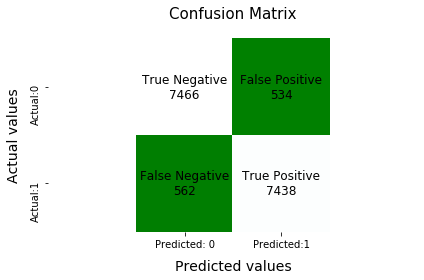

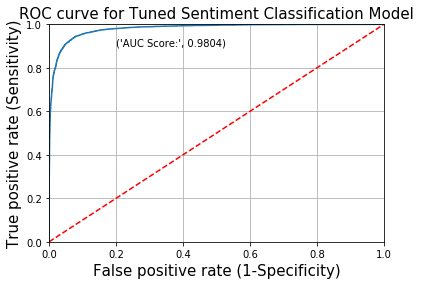

,Model_Name,Precision,Recall,Accuracy_score,F1-score,AUC_Score
0,LR_model_tuned,0.933016,0.92975,0.9315,0.93138,0.9804


In [55]:
tuned_LR_model = LogisticRegression(C=1, solver='lbfgs',random_state=10).fit(X_train_1,Y_train)

m = tuned_model_eval(tuned_LR_model,X_test_1,Y_test,model_name='LR_model_tuned')
tuned_results_table = tuned_results_table.append(m,ignore_index=True)
tuned_results_table

<h3 class="list-group-item list-group-item-action active" data-toggle="list"  role="tab" aria-controls="home"> 2. MULTINOMIAL NAIVE BAYES TUNED MODEL</h3>

Classification Report
               precision    recall  f1-score   support

           0       0.94      0.93      0.94      8000
           1       0.93      0.94      0.94      8000

    accuracy                           0.94     16000
   macro avg       0.94      0.94      0.94     16000
weighted avg       0.94      0.94      0.94     16000



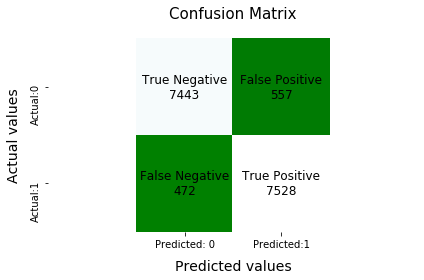

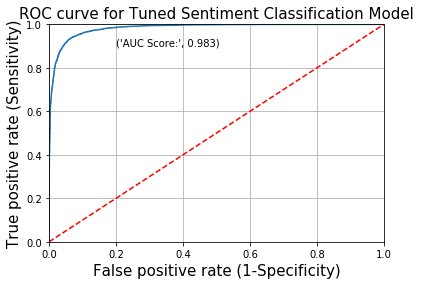

,Model_Name,Precision,Recall,Accuracy_score,F1-score,AUC_Score
0,LR_model_tuned,0.933016,0.92975,0.931500,0.931380,0.9804
1,MNB_model_tuned,0.931107,0.94100,0.935688,0.936027,0.9830


In [56]:
tuned_MNB_model = MultinomialNB(alpha=0.1).fit(X_train_1,Y_train)

m = tuned_model_eval(tuned_MNB_model,X_test_1,Y_test,model_name='MNB_model_tuned')
tuned_results_table = tuned_results_table.append(m,ignore_index=True)
tuned_results_table

<h3 class="list-group-item list-group-item-action active" data-toggle="list"  role="tab" aria-controls="home"> 3. RANDOM FOREST TUNED MODEL </h3>

Classification Report
               precision    recall  f1-score   support

           0       0.94      0.91      0.93      8000
           1       0.91      0.95      0.93      8000

    accuracy                           0.93     16000
   macro avg       0.93      0.93      0.93     16000
weighted avg       0.93      0.93      0.93     16000



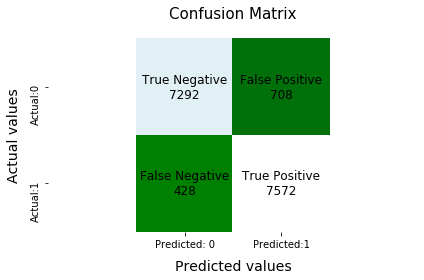

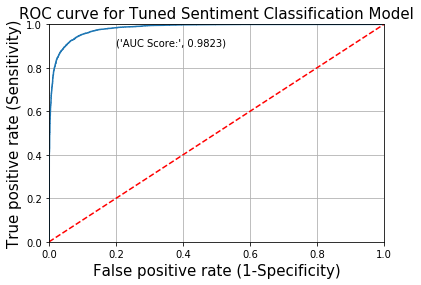

Wall time: 24min 3s


,Model_Name,Precision,Recall,Accuracy_score,F1-score,AUC_Score
0,LR_model_tuned,0.933016,0.92975,0.931500,0.931380,0.9804
1,MNB_model_tuned,0.931107,0.94100,0.935688,0.936027,0.9830
2,RF_model_tuned,0.914493,0.94650,0.929000,0.930221,0.9823


In [57]:
%%time
tuned_rf_model = RandomForestClassifier(criterion= 'entropy', max_depth= 200, n_estimators = 300,random_state=10).fit(X_train_1,Y_train)

m = tuned_model_eval(tuned_rf_model,X_test_1,Y_test,model_name='RF_model_tuned')
tuned_results_table = tuned_results_table.append(m,ignore_index=True)
tuned_results_table

<h3 class="list-group-item list-group-item-action active" data-toggle="list"  role="tab" aria-controls="home"> 4. XG BOOST TUNED MODEL </h3>

C:\Anaconda\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:56:12] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Classification Report
               precision    recall  f1-score   support

           0       0.92      0.93      0.93      8000
           1       0.93      0.92      0.93      8000

    accuracy                           0.93     16000
   macro avg       0.93      0.93      0.93     16000
weighted avg       0.93      0.93      0.93     16000



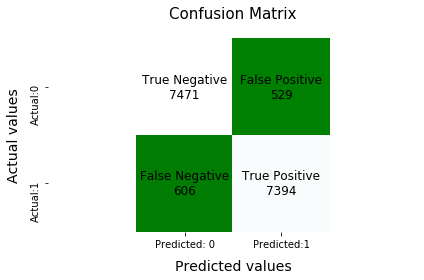

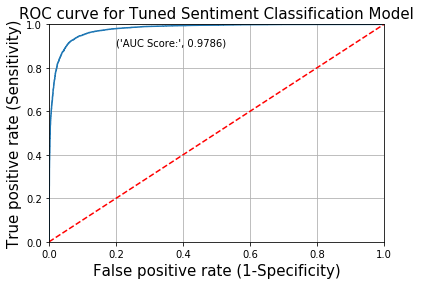

Wall time: 5min 37s


,Model_Name,Precision,Recall,Accuracy_score,F1-score,AUC_Score
0,LR_model_tuned,0.933016,0.92975,0.931500,0.931380,0.9804
1,MNB_model_tuned,0.931107,0.94100,0.935688,0.936027,0.9830
2,RF_model_tuned,0.914493,0.94650,0.929000,0.930221,0.9823
3,XGB_model_tuned,0.933232,0.92425,0.929063,0.928719,0.9786


In [58]:
%%time
tuned_xgb_model = XGBClassifier(eta = 0.5, max_depth= 25 , gamma = 1,random_state=10).fit(X_train_1,Y_train)

m = tuned_model_eval(tuned_xgb_model,X_test_1,Y_test,model_name='XGB_model_tuned')
tuned_results_table = tuned_results_table.append(m,ignore_index=True)
tuned_results_table

<h1 class="list-group-item list-group-item-action active" data-toggle="list"  role="tab" aria-controls="home"> SAMPLING</h1>

A sample is a **certain percentage of the population** using which we could make inferences about the whole population. There are different ways to determine the sample size. Here, we make use of the **Cochran's formula** to calculate the sample size of our test data for both positive and negative class.

The Cochran formula allows you to calculate an ideal sample size given a desired level of precision, desired confidence level, and the estimated proportion of the attribute present in the population.
The Cochran formula is:
 
<img src="cochran-1.jpeg">
 
 where, 
    e is the desired level of precision (i.e. the margin of error)\
    p is the (estimated) proportion of the population which has the attribute(Anomaly)\
    q is 1 – p

In our case, we take 
1. margin of error, e = 3%
2. Expected percentage of Anomaly in the population(test data), p = 5%
3. q = 95%

With the above chosen values we get **n0 = 203**

A Slight Modification of Cochran's formula for Sample size calculation:

<img src="cochran-2.jpeg">

Here **N = 8000** for positive and negative class each. Therefore substituting the values, we obtain the sample size for negative class and positive class as **200 samples each**


In [139]:
X_test['reviewText_processed'] =[" ".join(i) for i in X_test['reviewText_processed']]
test_data = pd.concat([X_test,Y_test],axis=1)
test_data.head()

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,reviewText,reviewText_processed,overall
66482,the greatest tea ever. i actually am a distrib...,great tea actually distributor product one cal...,1
35822,"The quality is good, however, I think they ski...",quality good think skimp seed many sunflower s...,0
61871,This is an item that I could no longer get in ...,item no longer store enjoy drinking thrill pro...,1
45107,Excellent for cleaning fruit and veggie. It is...,excellent cleaning fruit veggie very easy use ...,1
51785,"Most of the time, going gluten-free because of...",time go glutenfree recent celiac diagnosis fai...,1


In [169]:
random.seed(10)
test_0_indices = random.sample(list(test_data[test_data['overall']==0].index),200)
test_1_indices = random.sample(list(test_data[test_data['overall']==1].index),200)

In [173]:
test_data_0_samples = test_data.loc[test_0_indices,:]
test_data_1_samples = test_data.loc[test_1_indices,:]
sample_test_data = pd.concat([test_data_0_samples,test_data_1_samples],axis=0)
sample_test_data.head()

,reviewText,reviewText_processed,overall
944,Anything that contains fake crap like this cho...,anything contains fake crap like chocolatey ju...,0
15153,"STASH PREMIUM TEA has little to no taste, depe...",stash premium tea little no taste depend flavo...,0
35048,We put together the cups. Everything went wel...,put together cup everything go well t coffee c...,0
16296,I have tried multiple ways of brewing this and...,try multiple way brewing crappy tea sorry poun...,0
34663,This sounded so tasty from the reviews and the...,sound tasty review flavor enticingso order bre...,0


sample_test_data.to_csv("C:/Users/kamatchi/Documents/DSE Online Program/Project dataset/Sample_test_Dataset.csv")

With the randomly selected test samples of size 400, we would introduce a new variable - Manual sentiment where in the ratings have been given based on the reviewText_processed column based on the below assumption:
1. Only when the review represents a positive sentiment completely, rating has been marked as 1 (implying 5 star)
2. Any cases where there is a representation of negative sentiment/neutral, rating has been categorised as 0 (implying not 5 star)\
The manual sentiment may or may not be same as user given rating

This test sample data will be used to evaluate the performance of how well the above built sentiment classification models is able to predict the anamolies present in the data.

## Function for evaluating the Anomaly Classification

In [59]:
def anomaly_eval(Y_true,Y_pred,model_name='Anomaly_model'):
    cm = confusion_matrix(Y_true,Y_pred)
    
    print("Classification Report\n",classification_report(Y_true,Y_pred))
    
    #Plotting confusion matrix
    conf_matrix = pd.DataFrame(data=cm,columns = ['Predicted: 0','Predicted:1'],index=['Actual:0','Actual:1'])
    tags = ['True Negative','False Positive','False Negative','True Positive']
    tag_values = [str(value) for value in cm.flatten()]
    labels = [f'{i}\n{j}' for i, j in zip(tags,tag_values)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(conf_matrix, annot = labels, cmap = 'Blues',fmt='',annot_kws = {'fontsize':12,'color':'black'},cbar=False)
    plt.title ("Confusion Matrix", fontdict = {'size':15},pad=20)
    plt.xlabel("Predicted Anomaly values", fontdict = {'size':14}, labelpad = 10)
    plt.ylabel("Actual Anomaly values" , fontdict = {'size':14}, labelpad = 10)
    plt.axis('equal')
    plt.tight_layout()
    plt.show()
    
    #Creating a series of metrices to be consolidated in a dataframe
    model_metrics = pd.Series({'Model_name': model_name,'Precision-Weighted': precision_score(Y_true,Y_pred,average='weighted'),
                               'Recall-Weighted': recall_score(Y_true,Y_pred,average='weighted'),'Accuracy_score': accuracy_score(Y_true,Y_pred),
                               'F1-score-Weighted':f1_score(Y_true,Y_pred,average='weighted')})
    return model_metrics

<h1 class="list-group-item list-group-item-action active" data-toggle="list"  role="tab" aria-controls="home"> MODEL EVALUATION ON SAMPLE TEST DATA</h1>

### Reading the test sample data

In [60]:
test_samples = pd.read_excel("Sample_test_data_redefined.xlsx")
test_samples.head()

,Unnamed: 0,reviewText,reviewText_processed,overall,Manual Sentiment
0,944,Anything that contains fake crap like this cho...,anything contains fake crap like chocolatey ju...,0,0
1,15153,"STASH PREMIUM TEA has little to no taste, depe...",stash premium tea little no taste depend flavo...,0,0
2,35048,We put together the cups. Everything went wel...,put together cup everything go well t coffee c...,0,1
3,16296,I have tried multiple ways of brewing this and...,try multiple way brewing crappy tea sorry poun...,0,0
4,34663,This sounded so tasty from the reviews and the...,sound tasty review flavor enticingso order bre...,0,0


In [61]:
test_samples_1 = test_samples.copy()

In [62]:
#Getting the Anomalies based on Manual Sentiments:
test_samples_1['Anomaly'] = [0 if (test_samples_1.loc[i]['overall'] == test_samples_1.loc[i]['Manual Sentiment']) else 1 for i in range(len(test_samples_1))]

test_samples_1.head()

,Unnamed: 0,reviewText,reviewText_processed,overall,Manual Sentiment,Anomaly
0,944,Anything that contains fake crap like this cho...,anything contains fake crap like chocolatey ju...,0,0,0
1,15153,"STASH PREMIUM TEA has little to no taste, depe...",stash premium tea little no taste depend flavo...,0,0,0
2,35048,We put together the cups. Everything went wel...,put together cup everything go well t coffee c...,0,1,1
3,16296,I have tried multiple ways of brewing this and...,try multiple way brewing crappy tea sorry poun...,0,0,0
4,34663,This sounded so tasty from the reviews and the...,sound tasty review flavor enticingso order bre...,0,0,0


In [63]:
#Transforming the reviewText_processed of the sample test set
X_test_sample = vectoriser.transform(test_samples_1['reviewText_processed'])
Y_test_sample = test_samples_1['overall']

In [64]:
#Creating a dataframe to display the results for the different sentiment classifier models
Test_sample_results_table = pd.DataFrame(columns = cols)
#Creating a dataframe to display the results for the different Anomaly Detector models
Anomaly_results_table = pd.DataFrame(columns = ['Model_name','Precision-Weighted', 'Recall-Weighted', 'Accuracy_score', 'F1-score-Weighted'])

 <h2 class="list-group-item list-group-item-action active" data-toggle="list"  role="tab" aria-controls="home"> MODEL PERFORMANCE AS A SENTIMENT CLASSIFIER</h2> 

<h3 class="list-group-item list-group-item-action active" data-toggle="list"  role="tab" aria-controls="home"> 1. Logistic Regression Sentiment Classification model</h3>  

Classification Report
               precision    recall  f1-score   support

           0       0.94      0.94      0.94       200
           1       0.94      0.94      0.94       200

    accuracy                           0.94       400
   macro avg       0.94      0.94      0.94       400
weighted avg       0.94      0.94      0.94       400



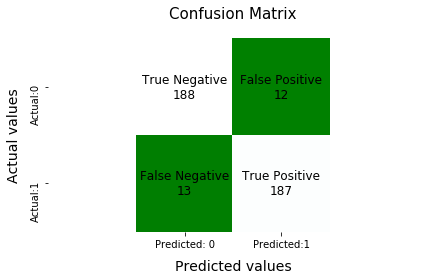

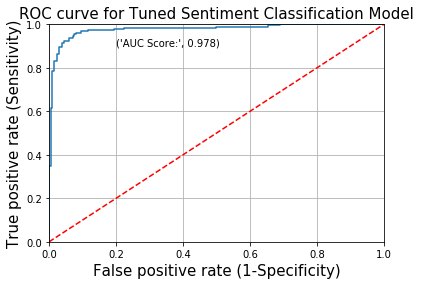

,Model_Name,Precision,Recall,Accuracy_score,F1-score,AUC_Score
0,LR_model_tuned_test_sample,0.939698,0.935,0.9375,0.937343,0.978


In [65]:
m = tuned_model_eval(tuned_LR_model,X_test_sample,Y_test_sample,model_name='LR_model_tuned_test_sample')
Test_sample_results_table = Test_sample_results_table.append(m,ignore_index=True)
Test_sample_results_table

<h3 class="list-group-item list-group-item-action active" data-toggle="list"  role="tab" aria-controls="home"> 2. Multinomial Naive Bayes Sentiment Classification model</h3>  

Classification Report
               precision    recall  f1-score   support

           0       0.96      0.95      0.95       200
           1       0.95      0.96      0.96       200

    accuracy                           0.95       400
   macro avg       0.96      0.95      0.95       400
weighted avg       0.96      0.95      0.95       400



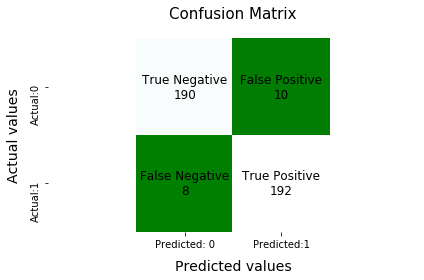

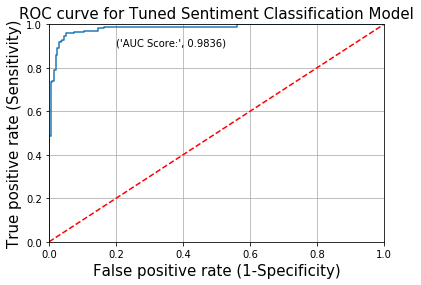

,Model_Name,Precision,Recall,Accuracy_score,F1-score,AUC_Score
0,LR_model_tuned_test_sample,0.939698,0.935,0.9375,0.937343,0.9780
1,MNB_model_tuned_test_sample,0.950495,0.960,0.9550,0.955224,0.9836


In [66]:
m = tuned_model_eval(tuned_MNB_model,X_test_sample,Y_test_sample,model_name='MNB_model_tuned_test_sample')
Test_sample_results_table = Test_sample_results_table.append(m,ignore_index=True)
Test_sample_results_table

<h3 class="list-group-item list-group-item-action active" data-toggle="list"  role="tab" aria-controls="home"> 3. Random Forest Sentiment Classification model</h3>

Classification Report
               precision    recall  f1-score   support

           0       0.95      0.92      0.93       200
           1       0.92      0.95      0.94       200

    accuracy                           0.94       400
   macro avg       0.94      0.94      0.93       400
weighted avg       0.94      0.94      0.93       400



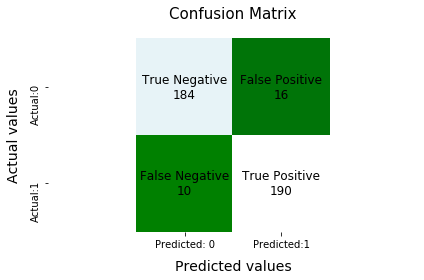

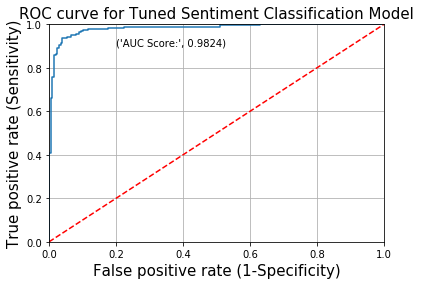

,Model_Name,Precision,Recall,Accuracy_score,F1-score,AUC_Score
0,LR_model_tuned_test_sample,0.939698,0.935,0.9375,0.937343,0.9780
1,MNB_model_tuned_test_sample,0.950495,0.960,0.9550,0.955224,0.9836
2,RF_model_tuned_test_sample,0.922330,0.950,0.9350,0.935961,0.9824


In [67]:
m = tuned_model_eval(tuned_rf_model,X_test_sample,Y_test_sample,model_name='RF_model_tuned_test_sample')
Test_sample_results_table = Test_sample_results_table.append(m,ignore_index=True)
Test_sample_results_table

<h3 class="list-group-item list-group-item-action active" data-toggle="list"  role="tab" aria-controls="home"> 4. XGBoost Sentiment Classification model</h3> 

Classification Report
               precision    recall  f1-score   support

           0       0.94      0.94      0.94       200
           1       0.94      0.94      0.94       200

    accuracy                           0.94       400
   macro avg       0.94      0.94      0.94       400
weighted avg       0.94      0.94      0.94       400



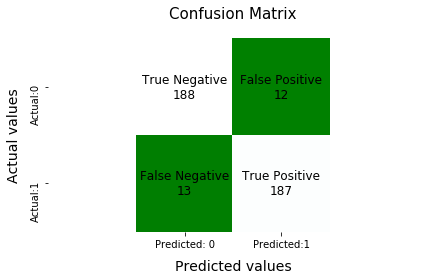

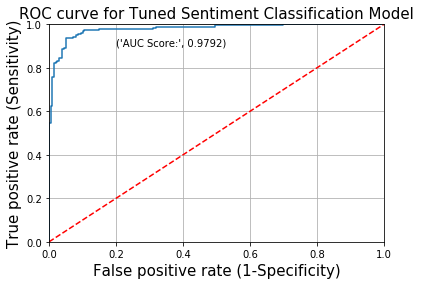

,Model_Name,Precision,Recall,Accuracy_score,F1-score,AUC_Score
0,LR_model_tuned_test_sample,0.939698,0.935,0.9375,0.937343,0.9780
1,MNB_model_tuned_test_sample,0.950495,0.960,0.9550,0.955224,0.9836
2,RF_model_tuned_test_sample,0.922330,0.950,0.9350,0.935961,0.9824
3,XGB_model_tuned_test_sample,0.939698,0.935,0.9375,0.937343,0.9792


In [68]:
m = tuned_model_eval(tuned_xgb_model,X_test_sample,Y_test_sample,model_name='XGB_model_tuned_test_sample')
Test_sample_results_table = Test_sample_results_table.append(m,ignore_index=True)
Test_sample_results_table

<h2 class="list-group-item list-group-item-action active" data-toggle="list"  role="tab" aria-controls="home"> COMPARISON OF METRICES FOR EVALUATING SENTIMENT CLASSIFIER </h2>

In [69]:
Test_sample_results_table.set_index('Model_Name',inplace=True)

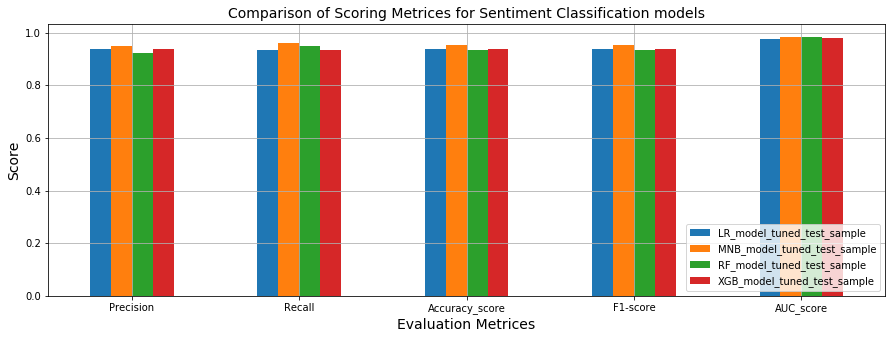

In [70]:
Test_sample_results_table.T.plot(kind='bar',figsize = (15,5),rot=0)
plt.xticks(np.arange(5),labels = ('Precision','Recall','Accuracy_score','F1-score','AUC_score'))
plt.xlabel('Evaluation Metrices',fontsize=14)
plt.ylabel('Score',fontsize=14)
plt.grid(True)
plt.title("Comparison of Scoring Metrices for Sentiment Classification models",fontsize=14)
plt.legend(loc='lower right')
plt.show()

We observe that as a sentiment classifier model - our tuned **Multinomial Naive Bayes is giving us the best scores** in terms of all metrices. Since F1 score is of our primary focus, we can see it is doing the best compared to other classifier models built

<h2 class="list-group-item list-group-item-action active" data-toggle="list"  role="tab" aria-controls="home"> PERFORMANCE OF SENTIMENT CLASSIFIER MODEL TO IDENTIFY THE ANOMALIES</h2>  

<h3 class="list-group-item list-group-item-action active" data-toggle="list"  role="tab" aria-controls="home"> 1.Logistic Regression Anomaly Detection Model</h3> 

In [71]:
#Model Predictions
Y_pred_LR = pd.DataFrame(tuned_LR_model.predict(X_test_sample),columns = ['Model_Predicted'])
Y_pred_proba_LR = pd.DataFrame(tuned_LR_model.predict_proba(X_test_sample)[:,1],columns = ['Model_Predicted_probability'])

LR_test = pd.concat([test_samples_1.iloc[:,:5],Y_pred_LR,Y_pred_proba_LR],axis=1)
LR_test.head()

,Unnamed: 0,reviewText,reviewText_processed,overall,Manual Sentiment,Model_Predicted,Model_Predicted_probability
0,944,Anything that contains fake crap like this cho...,anything contains fake crap like chocolatey ju...,0,0,0,0.029720
1,15153,"STASH PREMIUM TEA has little to no taste, depe...",stash premium tea little no taste depend flavo...,0,0,0,0.291311
2,35048,We put together the cups. Everything went wel...,put together cup everything go well t coffee c...,0,1,1,0.529657
3,16296,I have tried multiple ways of brewing this and...,try multiple way brewing crappy tea sorry poun...,0,0,0,0.123977
4,34663,This sounded so tasty from the reviews and the...,sound tasty review flavor enticingso order bre...,0,0,0,0.105551


In [72]:
#Anomaly predicted by the LR model:
LR_test['Model_predicted_anomaly'] = [0 if (LR_test.loc[i]['overall'] == LR_test.loc[i]['Model_Predicted']) else 1 for i in range(len(LR_test))]

LR_test.head()

,Unnamed: 0,reviewText,reviewText_processed,overall,Manual Sentiment,Model_Predicted,Model_Predicted_probability,Model_predicted_anomaly
0,944,Anything that contains fake crap like this cho...,anything contains fake crap like chocolatey ju...,0,0,0,0.029720,0
1,15153,"STASH PREMIUM TEA has little to no taste, depe...",stash premium tea little no taste depend flavo...,0,0,0,0.291311,0
2,35048,We put together the cups. Everything went wel...,put together cup everything go well t coffee c...,0,1,1,0.529657,1
3,16296,I have tried multiple ways of brewing this and...,try multiple way brewing crappy tea sorry poun...,0,0,0,0.123977,0
4,34663,This sounded so tasty from the reviews and the...,sound tasty review flavor enticingso order bre...,0,0,0,0.105551,0


In [73]:
#Comparison of the Model Predicted anomaly with reference to Manual sentiment which here stands as a reference of whether it is actually Anomaly or not:
LR_test_data = pd.concat([LR_test,test_samples_1['Anomaly']],axis=1)

LR_test_data.head()

,Unnamed: 0,reviewText,reviewText_processed,overall,Manual Sentiment,Model_Predicted,Model_Predicted_probability,Model_predicted_anomaly,Anomaly
0,944,Anything that contains fake crap like this cho...,anything contains fake crap like chocolatey ju...,0,0,0,0.029720,0,0
1,15153,"STASH PREMIUM TEA has little to no taste, depe...",stash premium tea little no taste depend flavo...,0,0,0,0.291311,0,0
2,35048,We put together the cups. Everything went wel...,put together cup everything go well t coffee c...,0,1,1,0.529657,1,1
3,16296,I have tried multiple ways of brewing this and...,try multiple way brewing crappy tea sorry poun...,0,0,0,0.123977,0,0
4,34663,This sounded so tasty from the reviews and the...,sound tasty review flavor enticingso order bre...,0,0,0,0.105551,0,0


Classification Report
               precision    recall  f1-score   support

           0       0.98      0.97      0.97       382
           1       0.48      0.67      0.56        18

    accuracy                           0.95       400
   macro avg       0.73      0.82      0.77       400
weighted avg       0.96      0.95      0.96       400



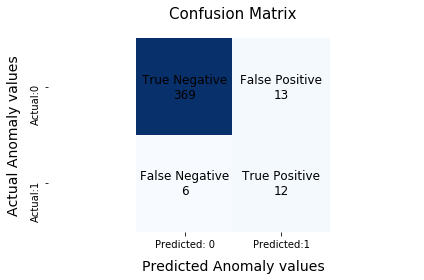

,Model_name,Precision-Weighted,Recall-Weighted,Accuracy_score,F1-score-Weighted
0,LR_anomaly,0.96132,0.9525,0.9525,0.956147


In [74]:
#Checking if model has predicted the actual anomalies:
Y_true_anomaly = LR_test_data['Anomaly']
Y_pred_anomaly = LR_test_data['Model_predicted_anomaly']
n = anomaly_eval(Y_true_anomaly,Y_pred_anomaly,'LR_anomaly')
Anomaly_results_table = Anomaly_results_table.append(n,ignore_index=True)
Anomaly_results_table

<h3 class="list-group-item list-group-item-action active" data-toggle="list"  role="tab" aria-controls="home"> 2.Multinomial Naive Bayes Anomaly Detection Model</h3>  

In [81]:
#Model Predictions
Y_pred_MNB = pd.DataFrame(tuned_MNB_model.predict(X_test_sample),columns = ['Model_Predicted'])
Y_pred_proba_MNB = pd.DataFrame(tuned_MNB_model.predict_proba(X_test_sample)[:,1],columns = ['Model_Predicted_probability'])

MNB_test = pd.concat([test_samples_1.iloc[:,:5],Y_pred_MNB,Y_pred_proba_MNB],axis=1)
MNB_test.head()

,Unnamed: 0,reviewText,reviewText_processed,overall,Manual Sentiment,Model_Predicted,Model_Predicted_probability
0,944,Anything that contains fake crap like this cho...,anything contains fake crap like chocolatey ju...,0,0,0,0.012006
1,15153,"STASH PREMIUM TEA has little to no taste, depe...",stash premium tea little no taste depend flavo...,0,0,0,0.043039
2,35048,We put together the cups. Everything went wel...,put together cup everything go well t coffee c...,0,1,0,0.437749
3,16296,I have tried multiple ways of brewing this and...,try multiple way brewing crappy tea sorry poun...,0,0,0,0.141104
4,34663,This sounded so tasty from the reviews and the...,sound tasty review flavor enticingso order bre...,0,0,0,0.001996


In [82]:
#Anomaly predicted by the MNB model:
MNB_test['Model_predicted_anomaly'] = [0 if (MNB_test.loc[i]['overall'] == MNB_test.loc[i]['Model_Predicted']) else 1 for i in range(len(MNB_test))]

MNB_test.head()

,Unnamed: 0,reviewText,reviewText_processed,overall,Manual Sentiment,Model_Predicted,Model_Predicted_probability,Model_predicted_anomaly
0,944,Anything that contains fake crap like this cho...,anything contains fake crap like chocolatey ju...,0,0,0,0.012006,0
1,15153,"STASH PREMIUM TEA has little to no taste, depe...",stash premium tea little no taste depend flavo...,0,0,0,0.043039,0
2,35048,We put together the cups. Everything went wel...,put together cup everything go well t coffee c...,0,1,0,0.437749,0
3,16296,I have tried multiple ways of brewing this and...,try multiple way brewing crappy tea sorry poun...,0,0,0,0.141104,0
4,34663,This sounded so tasty from the reviews and the...,sound tasty review flavor enticingso order bre...,0,0,0,0.001996,0


In [83]:
#Comparison of the Model Predicted anomaly with reference to Manual sentiment which here stands as a reference of whether it is actually Anomaly or not:
MNB_test_data = pd.concat([MNB_test,test_samples_1['Anomaly']],axis=1)

MNB_test_data.head()

,Unnamed: 0,reviewText,reviewText_processed,overall,Manual Sentiment,Model_Predicted,Model_Predicted_probability,Model_predicted_anomaly,Anomaly
0,944,Anything that contains fake crap like this cho...,anything contains fake crap like chocolatey ju...,0,0,0,0.012006,0,0
1,15153,"STASH PREMIUM TEA has little to no taste, depe...",stash premium tea little no taste depend flavo...,0,0,0,0.043039,0,0
2,35048,We put together the cups. Everything went wel...,put together cup everything go well t coffee c...,0,1,0,0.437749,0,1
3,16296,I have tried multiple ways of brewing this and...,try multiple way brewing crappy tea sorry poun...,0,0,0,0.141104,0,0
4,34663,This sounded so tasty from the reviews and the...,sound tasty review flavor enticingso order bre...,0,0,0,0.001996,0,0


Classification Report
               precision    recall  f1-score   support

           0       0.97      0.97      0.97       382
           1       0.39      0.39      0.39        18

    accuracy                           0.94       400
   macro avg       0.68      0.68      0.68       400
weighted avg       0.94      0.94      0.94       400



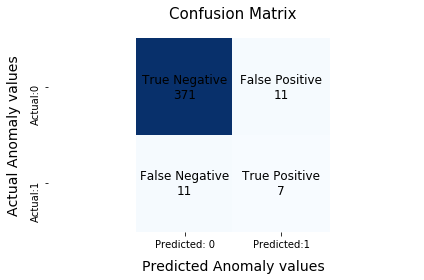

,Model_name,Precision-Weighted,Recall-Weighted,Accuracy_score,F1-score-Weighted
0,LR_anomaly,0.96132,0.9525,0.9525,0.956147
1,MNB_anomaly,0.94500,0.9450,0.9450,0.945000


In [78]:
#Checking if model has predicted the actual anomalies:
Y_true_anomaly = MNB_test_data['Anomaly']
Y_pred_anomaly = MNB_test_data['Model_predicted_anomaly']
n = anomaly_eval(Y_true_anomaly,Y_pred_anomaly,'MNB_anomaly')
Anomaly_results_table = Anomaly_results_table.append(n,ignore_index=True)
Anomaly_results_table

<h3 class="list-group-item list-group-item-action active" data-toggle="list"  role="tab" aria-controls="home"> 3. Random Forest Anomaly Detection Model</h3> 

In [84]:
#Model Predictions
Y_pred_RF = pd.DataFrame(tuned_rf_model.predict(X_test_sample),columns = ['Model_Predicted'])
Y_pred_proba_RF = pd.DataFrame(tuned_rf_model.predict_proba(X_test_sample)[:,1],columns = ['Model_Predicted_probability'])

RF_test = pd.concat([test_samples_1.iloc[:,:5],Y_pred_RF,Y_pred_proba_RF],axis=1)
RF_test.head()

,Unnamed: 0,reviewText,reviewText_processed,overall,Manual Sentiment,Model_Predicted,Model_Predicted_probability
0,944,Anything that contains fake crap like this cho...,anything contains fake crap like chocolatey ju...,0,0,0,0.233741
1,15153,"STASH PREMIUM TEA has little to no taste, depe...",stash premium tea little no taste depend flavo...,0,0,0,0.138987
2,35048,We put together the cups. Everything went wel...,put together cup everything go well t coffee c...,0,1,1,0.522041
3,16296,I have tried multiple ways of brewing this and...,try multiple way brewing crappy tea sorry poun...,0,0,1,0.511863
4,34663,This sounded so tasty from the reviews and the...,sound tasty review flavor enticingso order bre...,0,0,0,0.184678


In [85]:
#Anomaly predicted by the RF model:
RF_test['Model_predicted_anomaly'] = [0 if (RF_test.loc[i]['overall'] == RF_test.loc[i]['Model_Predicted']) else 1 for i in range(len(RF_test))]

RF_test.head()

,Unnamed: 0,reviewText,reviewText_processed,overall,Manual Sentiment,Model_Predicted,Model_Predicted_probability,Model_predicted_anomaly
0,944,Anything that contains fake crap like this cho...,anything contains fake crap like chocolatey ju...,0,0,0,0.233741,0
1,15153,"STASH PREMIUM TEA has little to no taste, depe...",stash premium tea little no taste depend flavo...,0,0,0,0.138987,0
2,35048,We put together the cups. Everything went wel...,put together cup everything go well t coffee c...,0,1,1,0.522041,1
3,16296,I have tried multiple ways of brewing this and...,try multiple way brewing crappy tea sorry poun...,0,0,1,0.511863,1
4,34663,This sounded so tasty from the reviews and the...,sound tasty review flavor enticingso order bre...,0,0,0,0.184678,0


In [86]:
#Comparison of the Model Predicted anomaly with reference to Manual sentiment which here stands as a reference of whether it is actually Anomaly or not:
RF_test_data = pd.concat([RF_test,test_samples_1['Anomaly']],axis=1)

RF_test_data.head()

,Unnamed: 0,reviewText,reviewText_processed,overall,Manual Sentiment,Model_Predicted,Model_Predicted_probability,Model_predicted_anomaly,Anomaly
0,944,Anything that contains fake crap like this cho...,anything contains fake crap like chocolatey ju...,0,0,0,0.233741,0,0
1,15153,"STASH PREMIUM TEA has little to no taste, depe...",stash premium tea little no taste depend flavo...,0,0,0,0.138987,0,0
2,35048,We put together the cups. Everything went wel...,put together cup everything go well t coffee c...,0,1,1,0.522041,1,1
3,16296,I have tried multiple ways of brewing this and...,try multiple way brewing crappy tea sorry poun...,0,0,1,0.511863,1,0
4,34663,This sounded so tasty from the reviews and the...,sound tasty review flavor enticingso order bre...,0,0,0,0.184678,0,0


Classification Report
               precision    recall  f1-score   support

           0       0.98      0.96      0.97       382
           1       0.42      0.61      0.50        18

    accuracy                           0.94       400
   macro avg       0.70      0.79      0.74       400
weighted avg       0.96      0.94      0.95       400



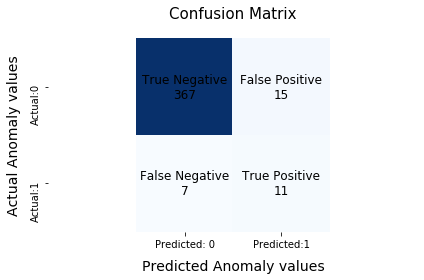

,Model_name,Precision-Weighted,Recall-Weighted,Accuracy_score,F1-score-Weighted
0,LR_anomaly,0.961320,0.9525,0.9525,0.956147
1,MNB_anomaly,0.945000,0.9450,0.9450,0.945000
2,RF_anomaly,0.956164,0.9450,0.9450,0.949709


In [87]:
#Checking if model has predicted the actual anomalies:
Y_true_anomaly = RF_test_data['Anomaly']
Y_pred_anomaly = RF_test_data['Model_predicted_anomaly']
n = anomaly_eval(Y_true_anomaly,Y_pred_anomaly,'RF_anomaly')
Anomaly_results_table = Anomaly_results_table.append(n,ignore_index=True)
Anomaly_results_table

<h3 class="list-group-item list-group-item-action active" data-toggle="list"  role="tab" aria-controls="home"> 4.XG Boost Anomaly Detection Model</h3>  

In [88]:
#Model Predictions
Y_pred_XGB = pd.DataFrame(tuned_xgb_model.predict(X_test_sample),columns = ['Model_Predicted'])
Y_pred_proba_XGB = pd.DataFrame(tuned_xgb_model.predict_proba(X_test_sample)[:,1],columns = ['Model_Predicted_probability'])

XGB_test = pd.concat([test_samples_1.iloc[:,:5],Y_pred_XGB,Y_pred_proba_XGB],axis=1)
XGB_test.head()

,Unnamed: 0,reviewText,reviewText_processed,overall,Manual Sentiment,Model_Predicted,Model_Predicted_probability
0,944,Anything that contains fake crap like this cho...,anything contains fake crap like chocolatey ju...,0,0,0,0.000555
1,15153,"STASH PREMIUM TEA has little to no taste, depe...",stash premium tea little no taste depend flavo...,0,0,0,0.035118
2,35048,We put together the cups. Everything went wel...,put together cup everything go well t coffee c...,0,1,0,0.380043
3,16296,I have tried multiple ways of brewing this and...,try multiple way brewing crappy tea sorry poun...,0,0,0,0.030515
4,34663,This sounded so tasty from the reviews and the...,sound tasty review flavor enticingso order bre...,0,0,0,0.001207


In [89]:
#Anomaly predicted by the XGBoost model:
XGB_test['Model_predicted_anomaly'] = [0 if (XGB_test.loc[i]['overall'] == XGB_test.loc[i]['Model_Predicted']) else 1 for i in range(len(XGB_test))]

XGB_test.head()

,Unnamed: 0,reviewText,reviewText_processed,overall,Manual Sentiment,Model_Predicted,Model_Predicted_probability,Model_predicted_anomaly
0,944,Anything that contains fake crap like this cho...,anything contains fake crap like chocolatey ju...,0,0,0,0.000555,0
1,15153,"STASH PREMIUM TEA has little to no taste, depe...",stash premium tea little no taste depend flavo...,0,0,0,0.035118,0
2,35048,We put together the cups. Everything went wel...,put together cup everything go well t coffee c...,0,1,0,0.380043,0
3,16296,I have tried multiple ways of brewing this and...,try multiple way brewing crappy tea sorry poun...,0,0,0,0.030515,0
4,34663,This sounded so tasty from the reviews and the...,sound tasty review flavor enticingso order bre...,0,0,0,0.001207,0


In [90]:
#Comparison of the Model Predicted anomaly with reference to Manual sentiment which here stands as a reference of whether it is actually Anomaly or not:
XGB_test_data = pd.concat([XGB_test,test_samples_1['Anomaly']],axis=1)

XGB_test_data.head()

,Unnamed: 0,reviewText,reviewText_processed,overall,Manual Sentiment,Model_Predicted,Model_Predicted_probability,Model_predicted_anomaly,Anomaly
0,944,Anything that contains fake crap like this cho...,anything contains fake crap like chocolatey ju...,0,0,0,0.000555,0,0
1,15153,"STASH PREMIUM TEA has little to no taste, depe...",stash premium tea little no taste depend flavo...,0,0,0,0.035118,0,0
2,35048,We put together the cups. Everything went wel...,put together cup everything go well t coffee c...,0,1,0,0.380043,0,1
3,16296,I have tried multiple ways of brewing this and...,try multiple way brewing crappy tea sorry poun...,0,0,0,0.030515,0,0
4,34663,This sounded so tasty from the reviews and the...,sound tasty review flavor enticingso order bre...,0,0,0,0.001207,0,0


Classification Report
               precision    recall  f1-score   support

           0       0.97      0.95      0.96       382
           1       0.28      0.39      0.33        18

    accuracy                           0.93       400
   macro avg       0.63      0.67      0.64       400
weighted avg       0.94      0.93      0.93       400



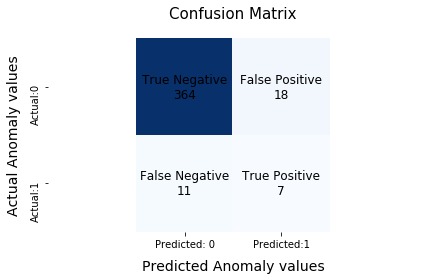

,Model_name,Precision-Weighted,Recall-Weighted,Accuracy_score,F1-score-Weighted
0,LR_anomaly,0.961320,0.9525,0.9525,0.956147
1,MNB_anomaly,0.945000,0.9450,0.9450,0.945000
2,RF_anomaly,0.956164,0.9450,0.9450,0.949709
3,XGB_Anomaly,0.939587,0.9275,0.9275,0.933066


In [91]:
#Checking if model has predicted the actual anomalies:
Y_true_anomaly = XGB_test_data['Anomaly']
Y_pred_anomaly = XGB_test_data['Model_predicted_anomaly']
n = anomaly_eval(Y_true_anomaly,Y_pred_anomaly,'XGB_Anomaly')
Anomaly_results_table = Anomaly_results_table.append(n,ignore_index=True)
Anomaly_results_table

<h2 class="list-group-item list-group-item-action active" data-toggle="list"  role="tab" aria-controls="home"> COMPARISON OF METRICES FOR EVALUATING ANOMALY CLASSIFIER </h2>

In [92]:
Anomaly_results_table.set_index('Model_name',inplace=True)

In [93]:
Anomaly_results_table

,Precision-Weighted,Recall-Weighted,Accuracy_score,F1-score-Weighted
Model_name,,,,
LR_anomaly,0.961320,0.9525,0.9525,0.956147
MNB_anomaly,0.945000,0.9450,0.9450,0.945000
RF_anomaly,0.956164,0.9450,0.9450,0.949709
XGB_Anomaly,0.939587,0.9275,0.9275,0.933066


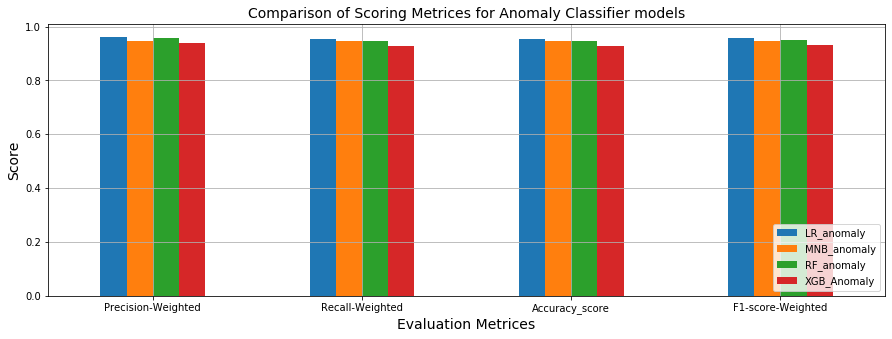

In [94]:
Anomaly_results_table.T.plot(kind='bar',figsize = (15,5),rot=0)
plt.xticks(np.arange(4),labels = ('Precision-Weighted','Recall-Weighted','Accuracy_score','F1-score-Weighted'))
plt.xlabel('Evaluation Metrices',fontsize=14)
plt.ylabel('Score',fontsize=14)
plt.grid(True)
plt.title("Comparison of Scoring Metrices for Anomaly Classifier models",fontsize=14)
plt.legend(loc='lower right')
plt.show()

It is quite interesting to observe that when it comes to Anomaly classification, the tuned Multinomial Naive Bayes Model which gave us best results as Sentiment classifier is not doing the best here. **Logistic Regression Sentiment Classifier model is performing better than others when it comes to Anomaly Classification**. 

**Interpretation of Results:**

Therefore we can conclude that at a **confidence interval of 95% and margin of error 3%**, the Weighted F1 scores of the different Anomaly Classifiers may range as follows:
    1. Logistic Regression - 92.61% to 98.61%
    2. Multinomial Naive Bayes - 91.5% to 97.5%
    3. Random Forest  - 91.9% to 97.9%
    4. XG Boost - 90.3% to 96.3%


**Observations:**
1. Ideally, we would expect that for a given dataset if a model is able to classify the sentiments properly, it should be able to identify the mismatch in the sentiments. But that is not what we see here from our experimentation.
2. It is not necessary that if a model is performing at its best in a certain use case like Sentiment classification would imply that it could be the same scenario when it is used as Anomaly Classifier.
3. This behaviour may be attributed to a fact that our sentiment classifier is not 100% accurate and this gap would have resulted in our models to predict certain extra records as Anomaly when they are actually not and vice versa. 

**Business Recommendation:**

We would recommend the Business (Client) to have recommendation system based on the Anomalies identified by our model. This system could send messages, mail or a call to their customers and suggest them to re-examine the feedback provided. This process is expected to improve the credibility of the ratings for a product and provide better user experience, especially for new customers.  